In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  ActivityEncoded
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953                1
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424                1
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722                1
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717                1
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164                1
...          ...      ...              ...       ...        ...       ...              ...
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000                4
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000                4
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000                4
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000                4
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000                4

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

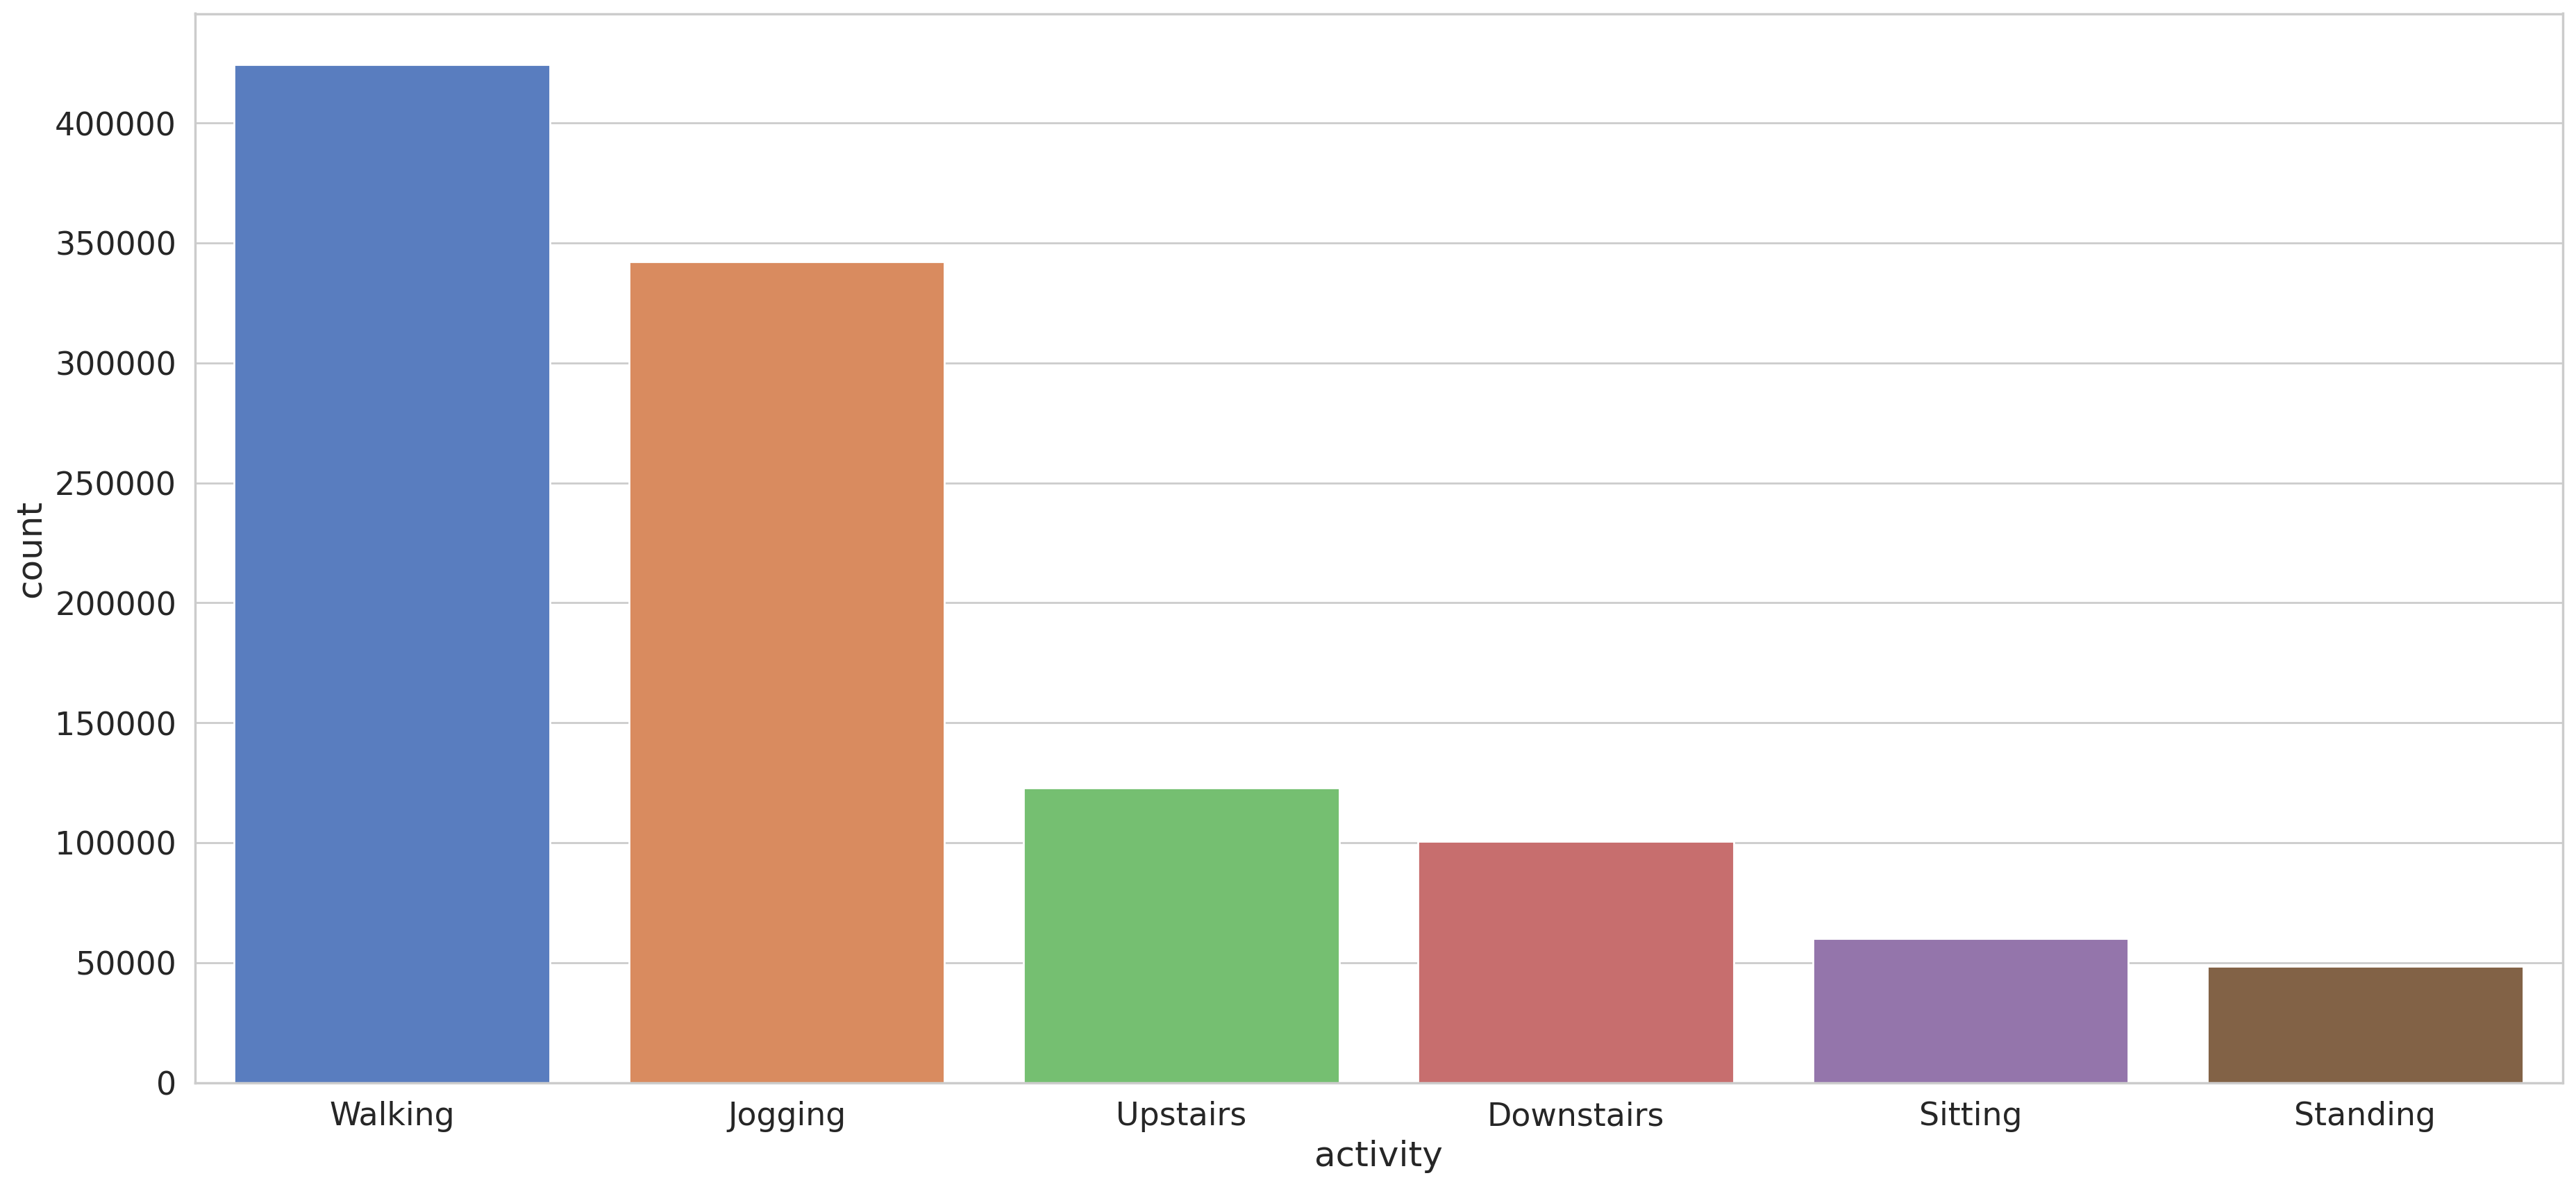

In [ ]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

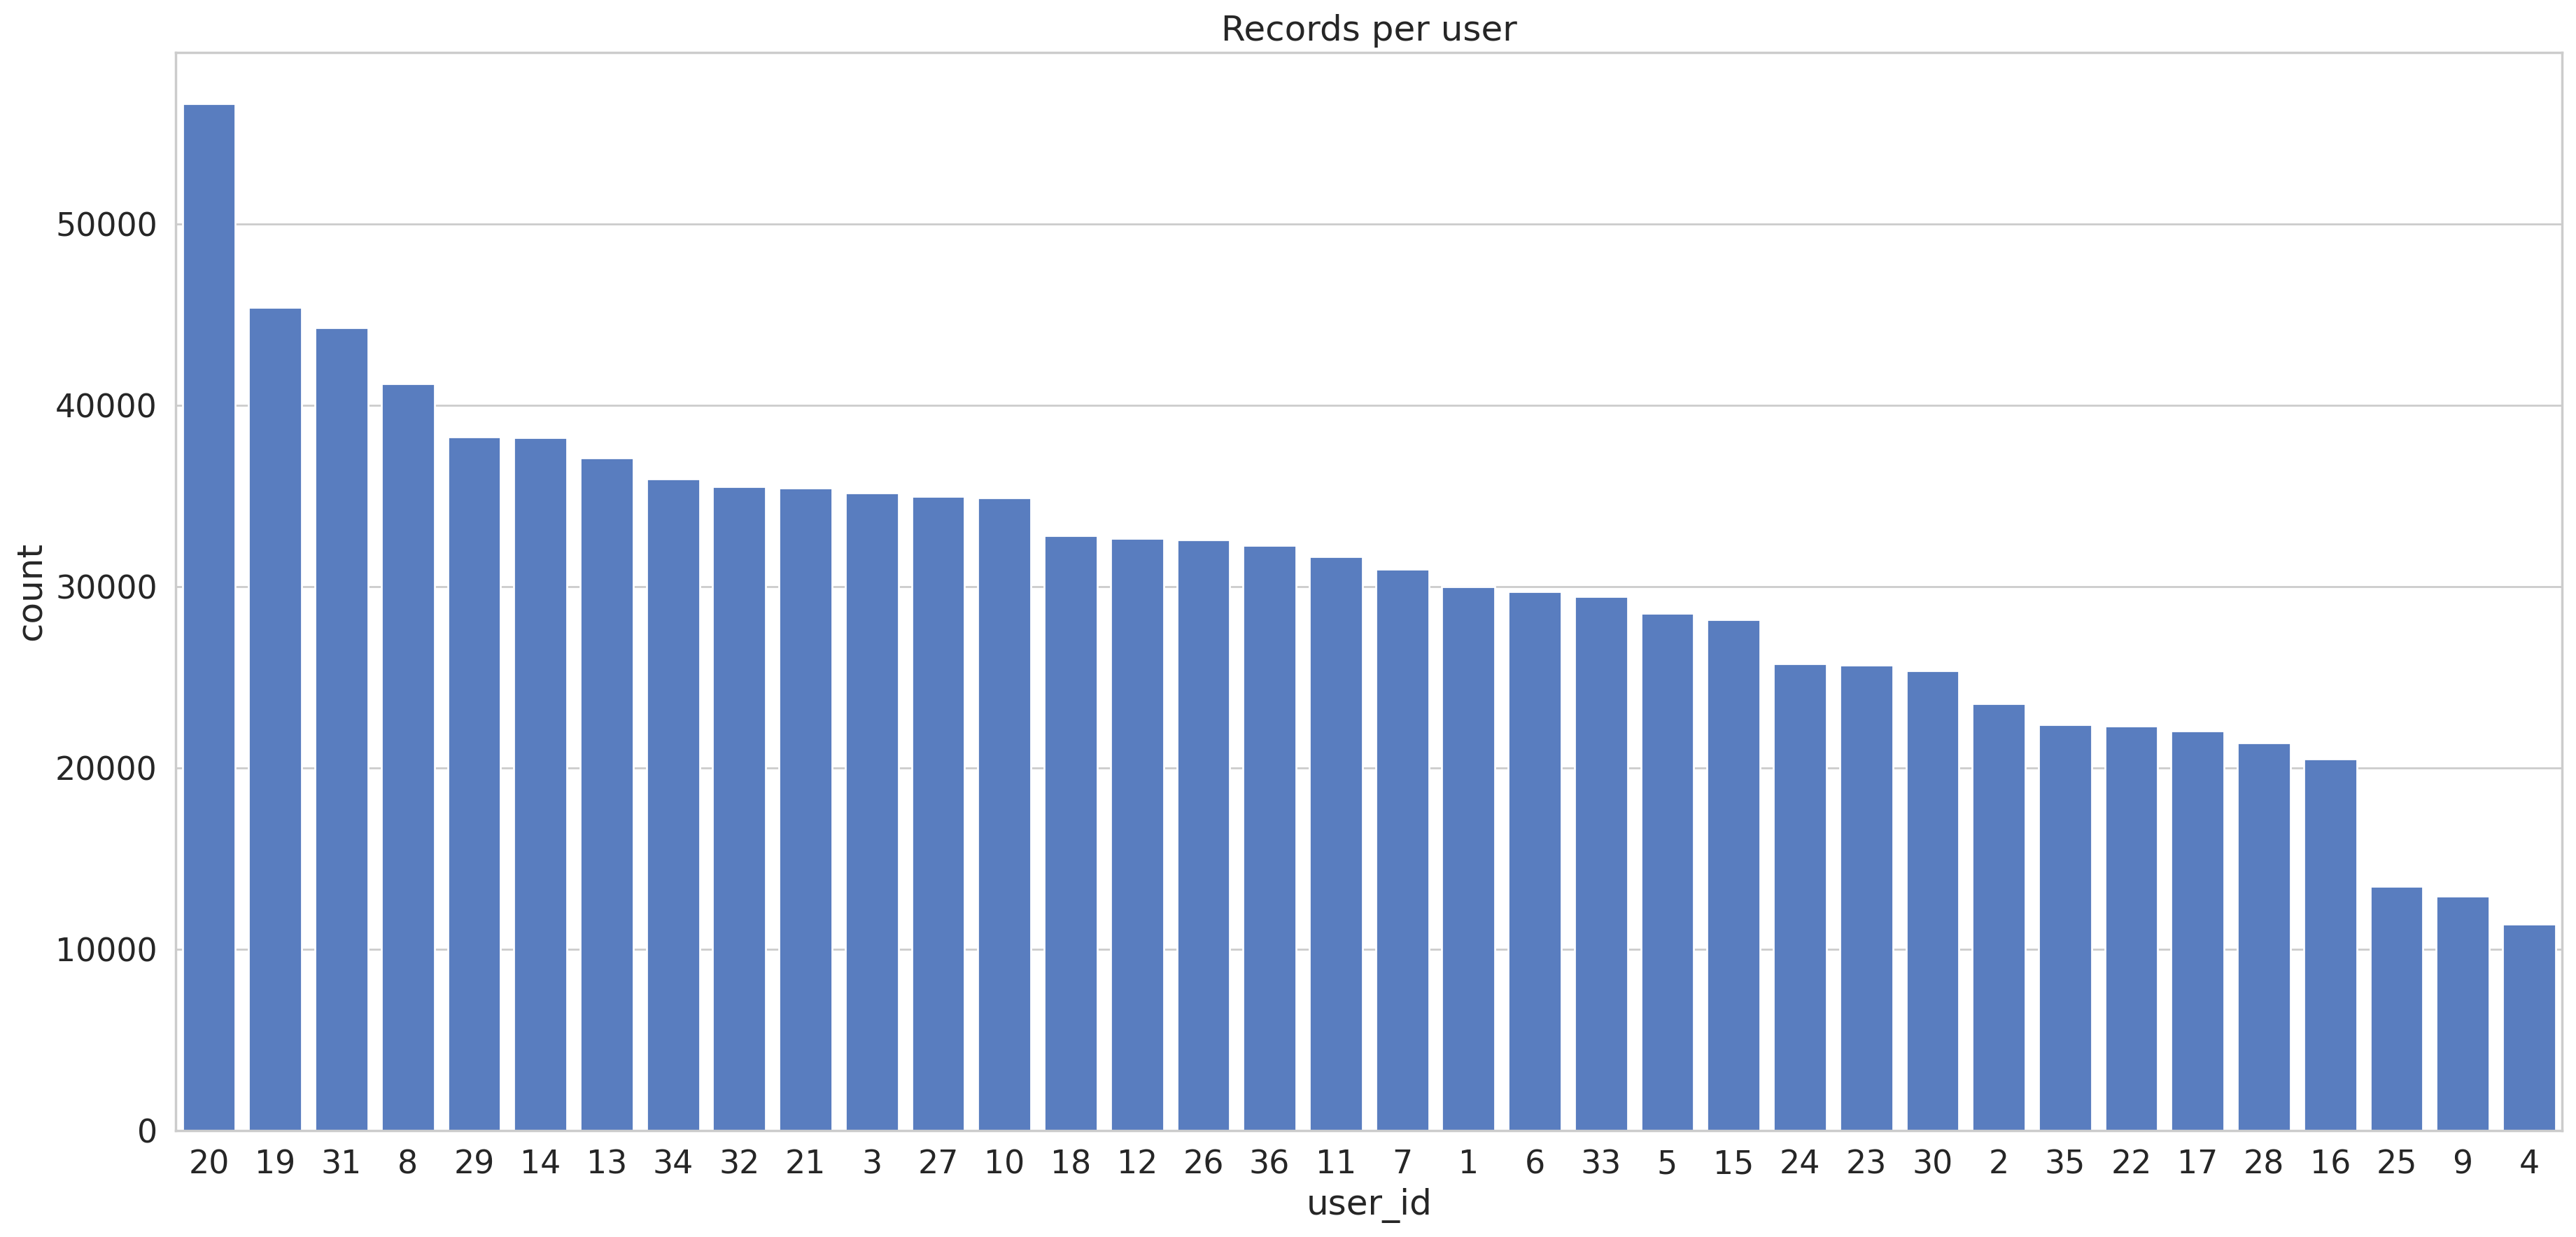

In [ ]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


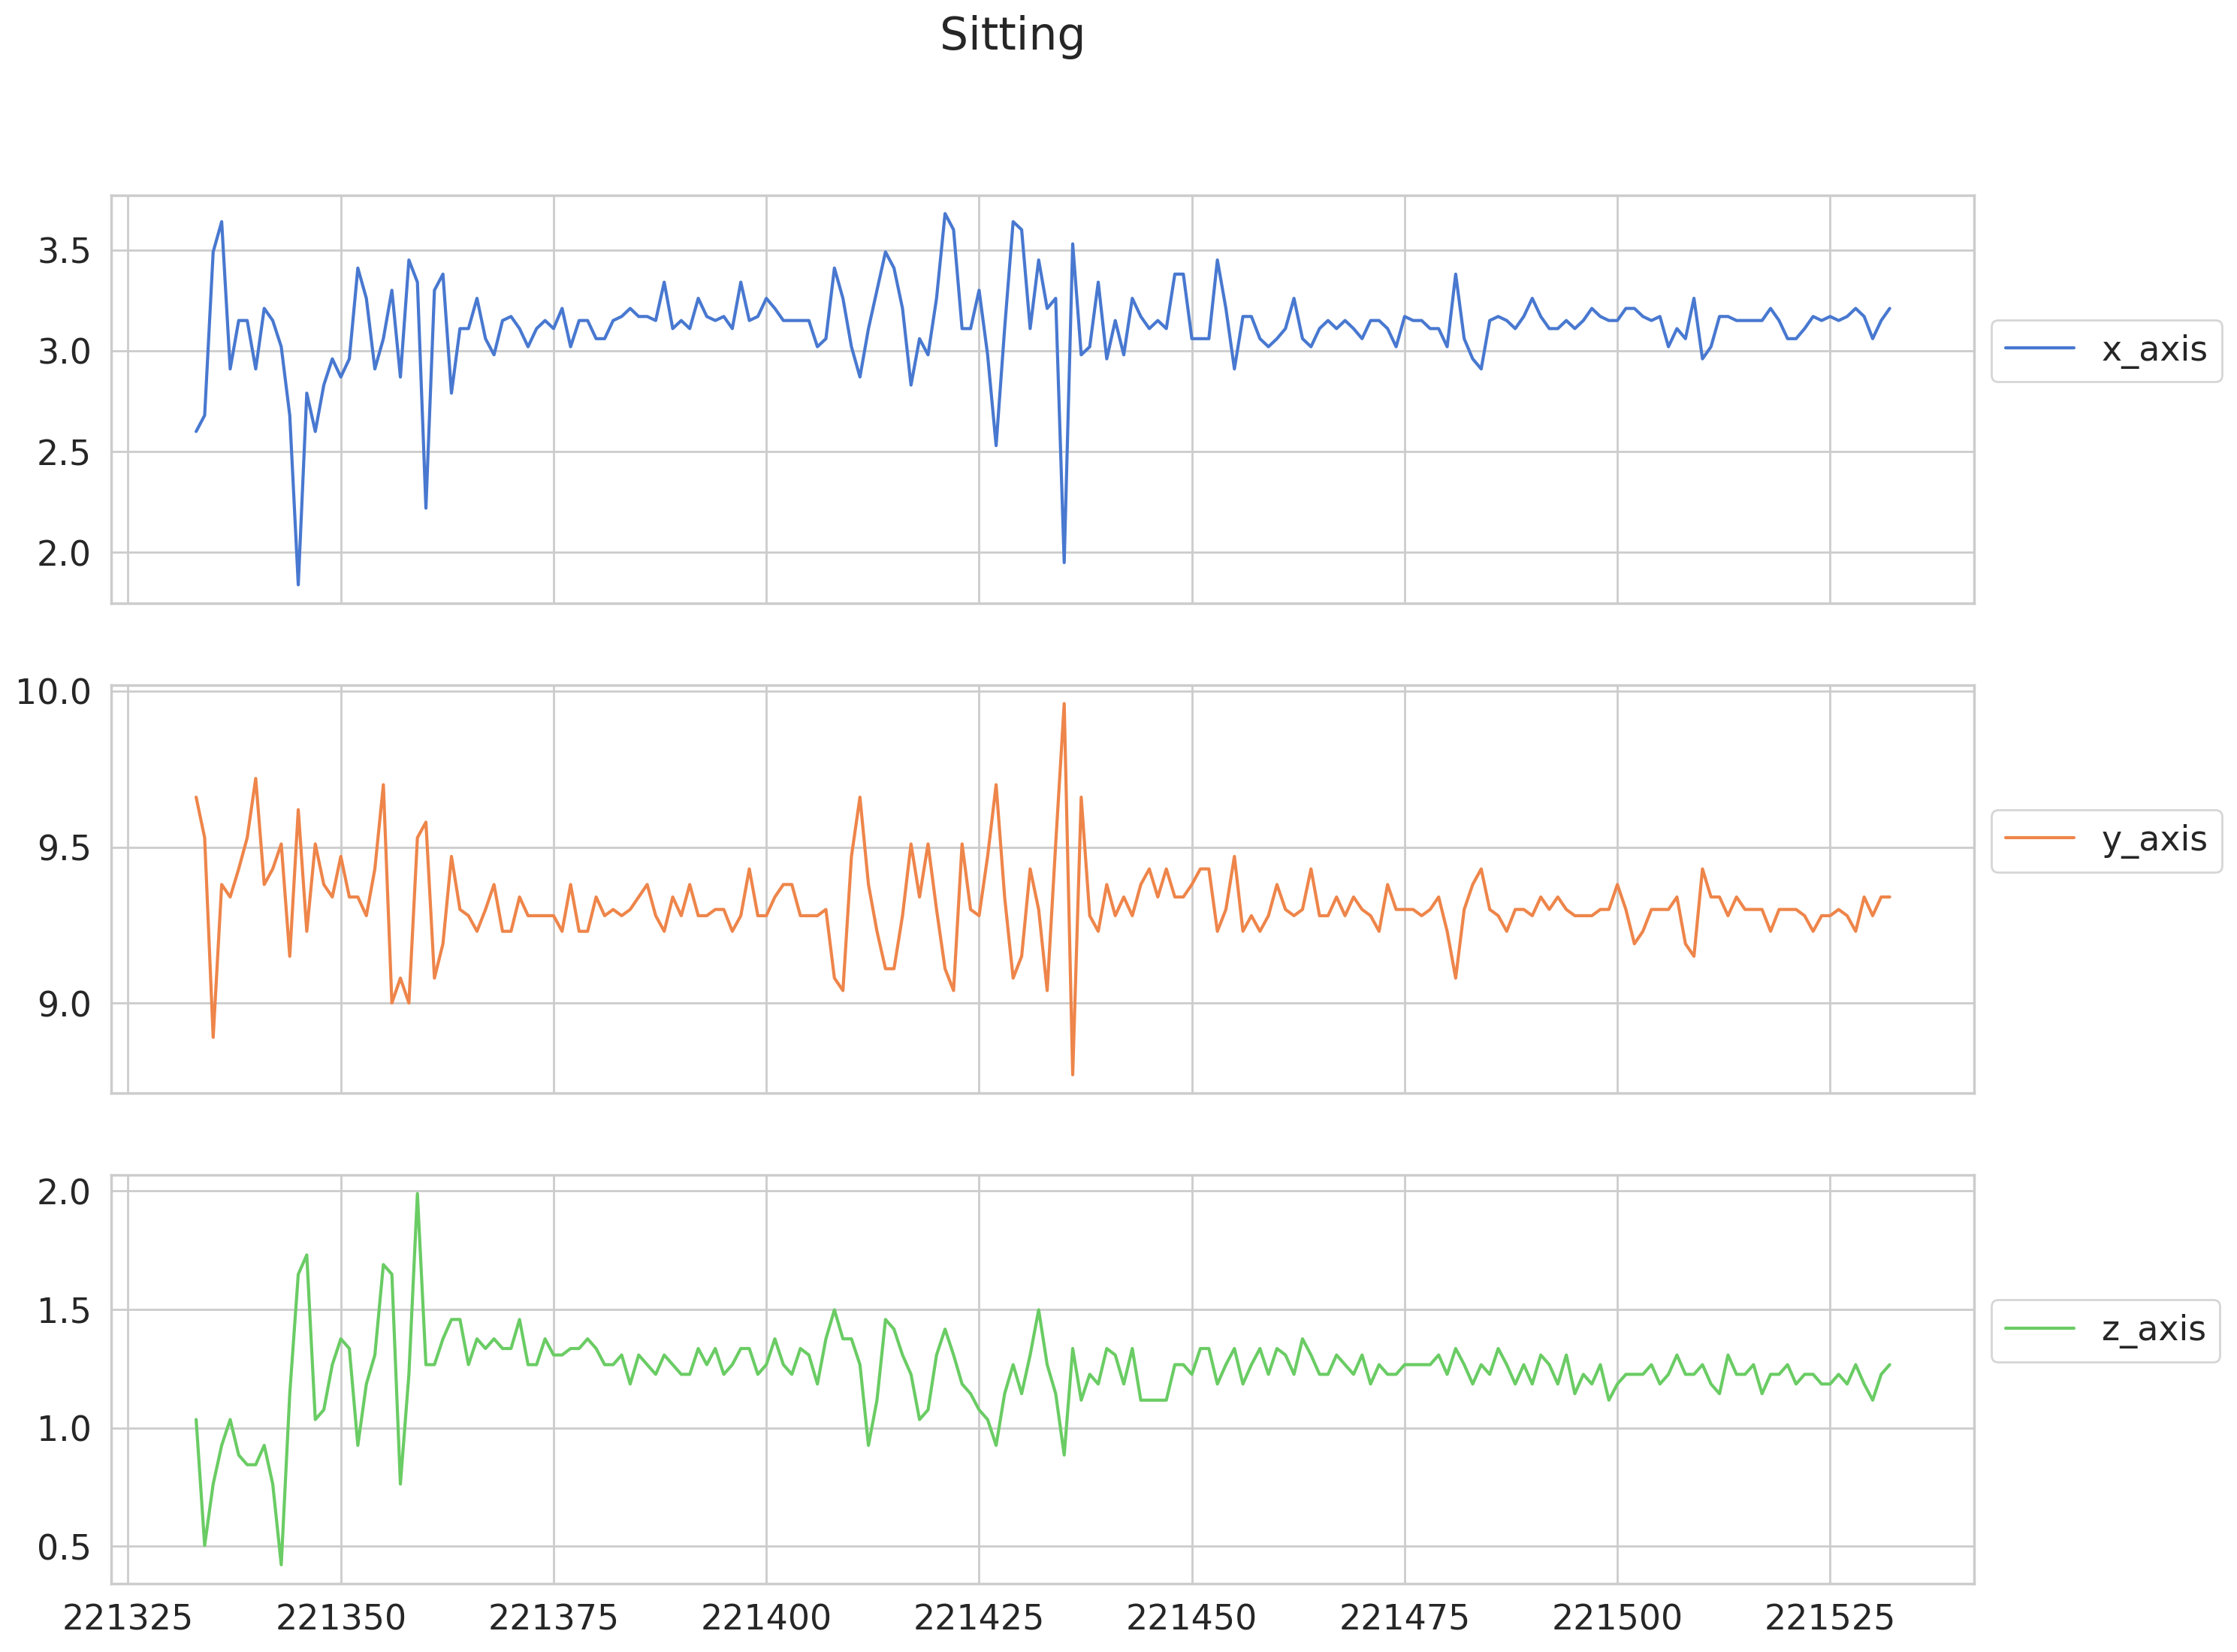

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [6]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  ActivityEncoded
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015                1
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001                1
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543                1
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089                1
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535                1
...          ...      ...              ...       ...       ...       ...              ...
1098200       19  Sitting  131623331483000  1.194254 -1.132300  0.342105                4
1098201       19  Sitting  131623371431000  1.199726 -1.119190  0.350202                4
1098202       19  Sitting  131623411592000  1.205198 -1.109654  0.342105                4
1098203       19  Sitting  131623491487000  1.194254 -1.119190  0.350202                4
1098204       19  Sitting  131623531465000  1.177839 -1.103695  0.325911                4

[1098204 rows x 7 columns]

In [7]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70281, 50, 3) (70281, 1)
(21964, 50, 3) (21964, 1)


In [8]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(70281, 50, 3) (70281, 6) (21964, 50, 3) (21964, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 6)

# GRU1


In [11]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 59718 (233.27 KB)
Trainable params: 59718 (233.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
69/69 [==============================] - 8s 32ms/step - loss: 1.2318 - accuracy: 0.5739 - val_loss: 0.8173 - val_accuracy: 0.7194
Epoch 2/10
69/69 [==============================] - 1s 17ms/step - loss: 0.7186 - accuracy: 0.7484 - val_loss: 0.5705 - val_accuracy: 0.7965
Epoch 3/10
69/69 [==============================] - 1s 16ms/step - loss: 0.5446 - accuracy: 0.8048 - val_loss: 0.4819 - val_accuracy: 0.8240
Epoch 4/10
69/69 [==============================] - 1s 16ms/step - loss: 0.4699 - accuracy: 0.8286 - val_loss: 0.4147 - val_accuracy: 0.8425
Epoch 5/10
69/69 [==============================] - 1s 16ms/step - loss: 0.4274 - accuracy: 0.8404 - val_loss: 0.3850 - val_accuracy: 0.8529
Epoch 6/10
69/69 [==============================] - 1s 16ms/step - loss: 0.3952 - accuracy: 0.8506 - val_loss: 0.3648 - val_accuracy: 0.8581
Epoch 7/10
69/69 [==============================] - 1s 16ms/step - loss: 0.3634 - accuracy: 0.8622 - val_loss: 0.3551 - val_accuracy: 0.8682
Epoch 8/10
69

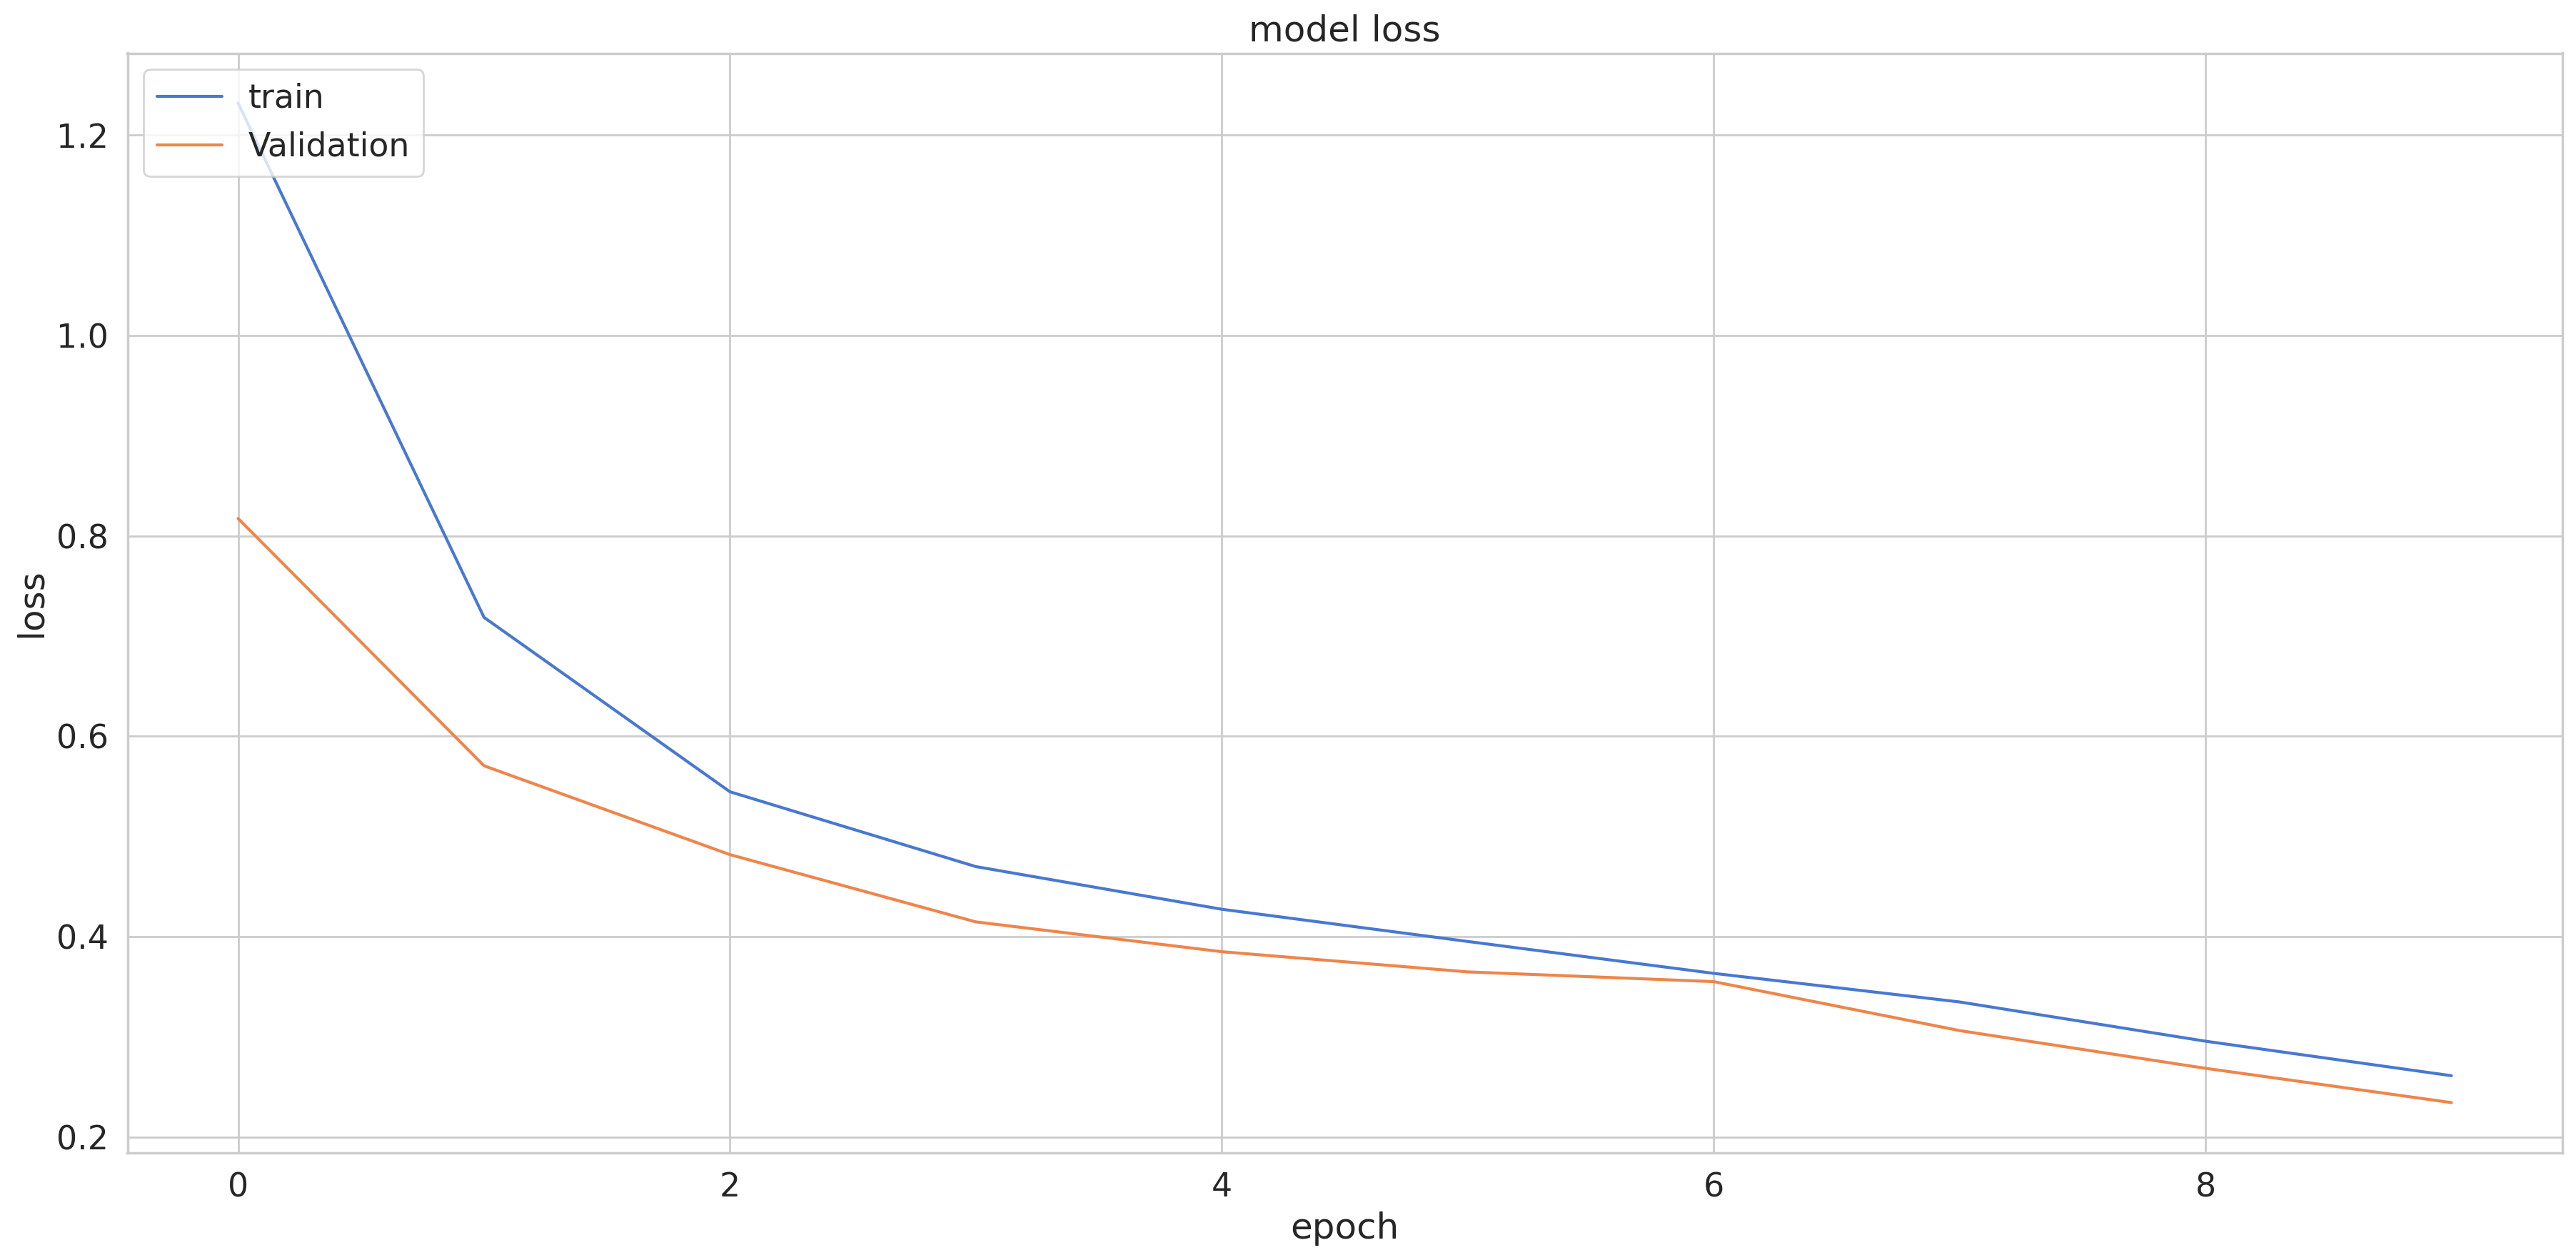

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

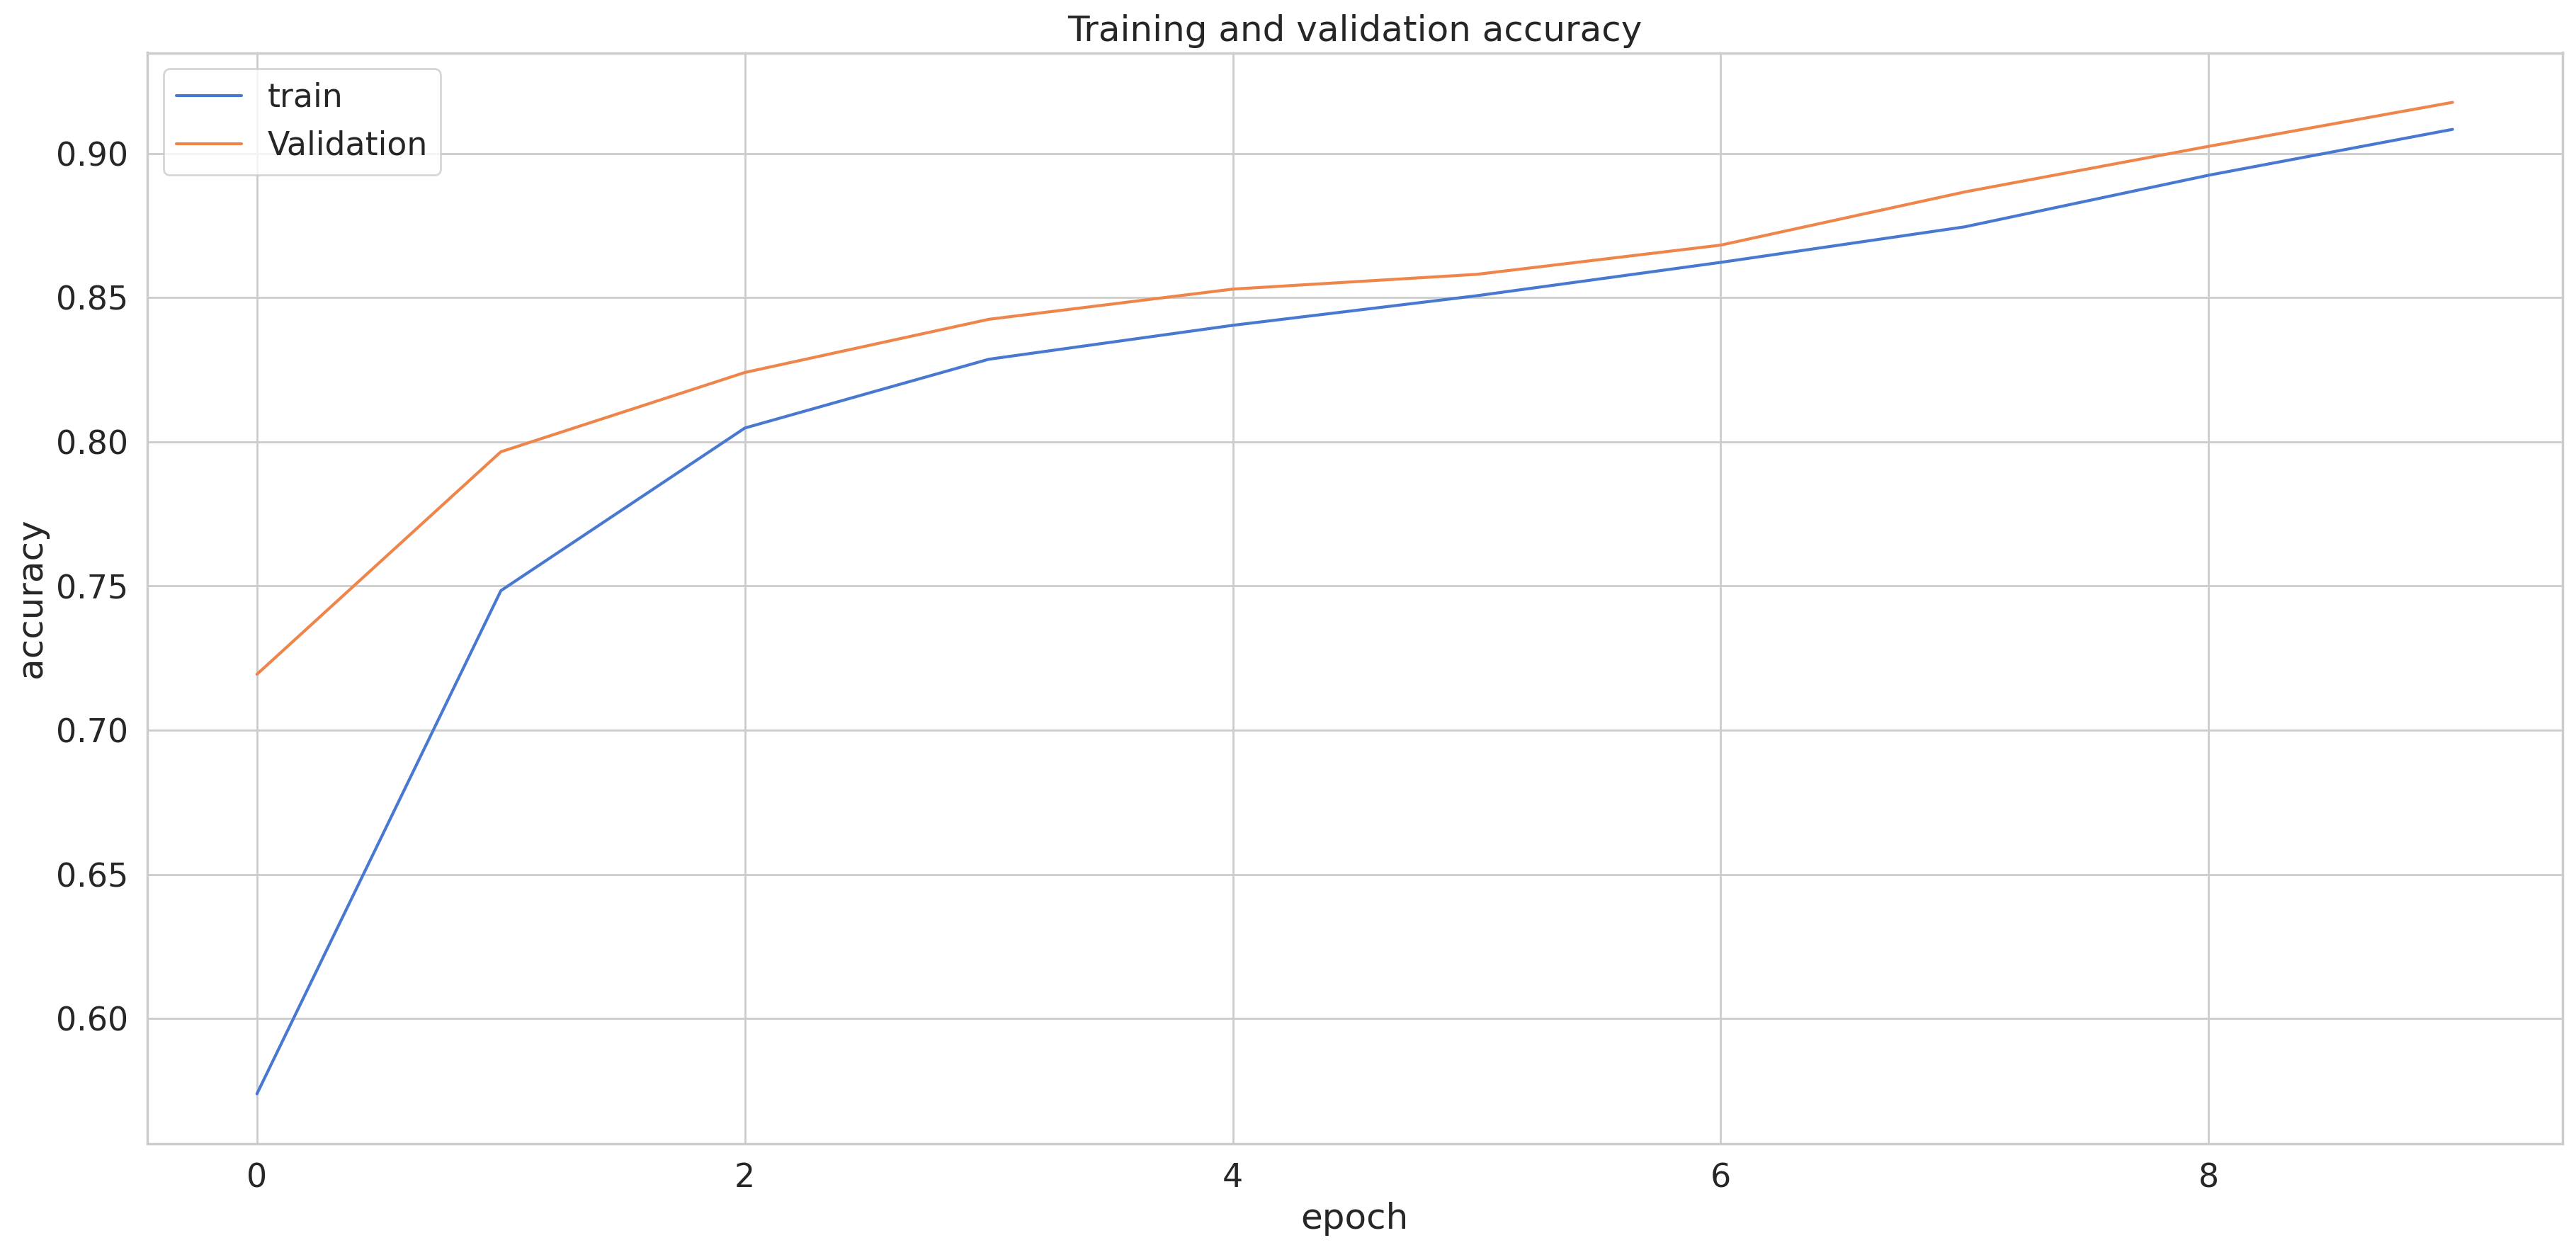

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 3s 4ms/step
f1_score =  0.9164468898226557
0.9184574758696048
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8489
           1       0.97      0.98      0.98      6844
           2       0.72      0.76      0.74      2458
           3       0.79      0.62      0.69      2007
           4       0.97      0.96      0.97      1198
           5       0.93      0.97      0.95       968

    accuracy                           0.92     21964
   macro avg       0.89      0.88      0.88     21964
weighted avg       0.92      0.92      0.92     21964



<Axes: >

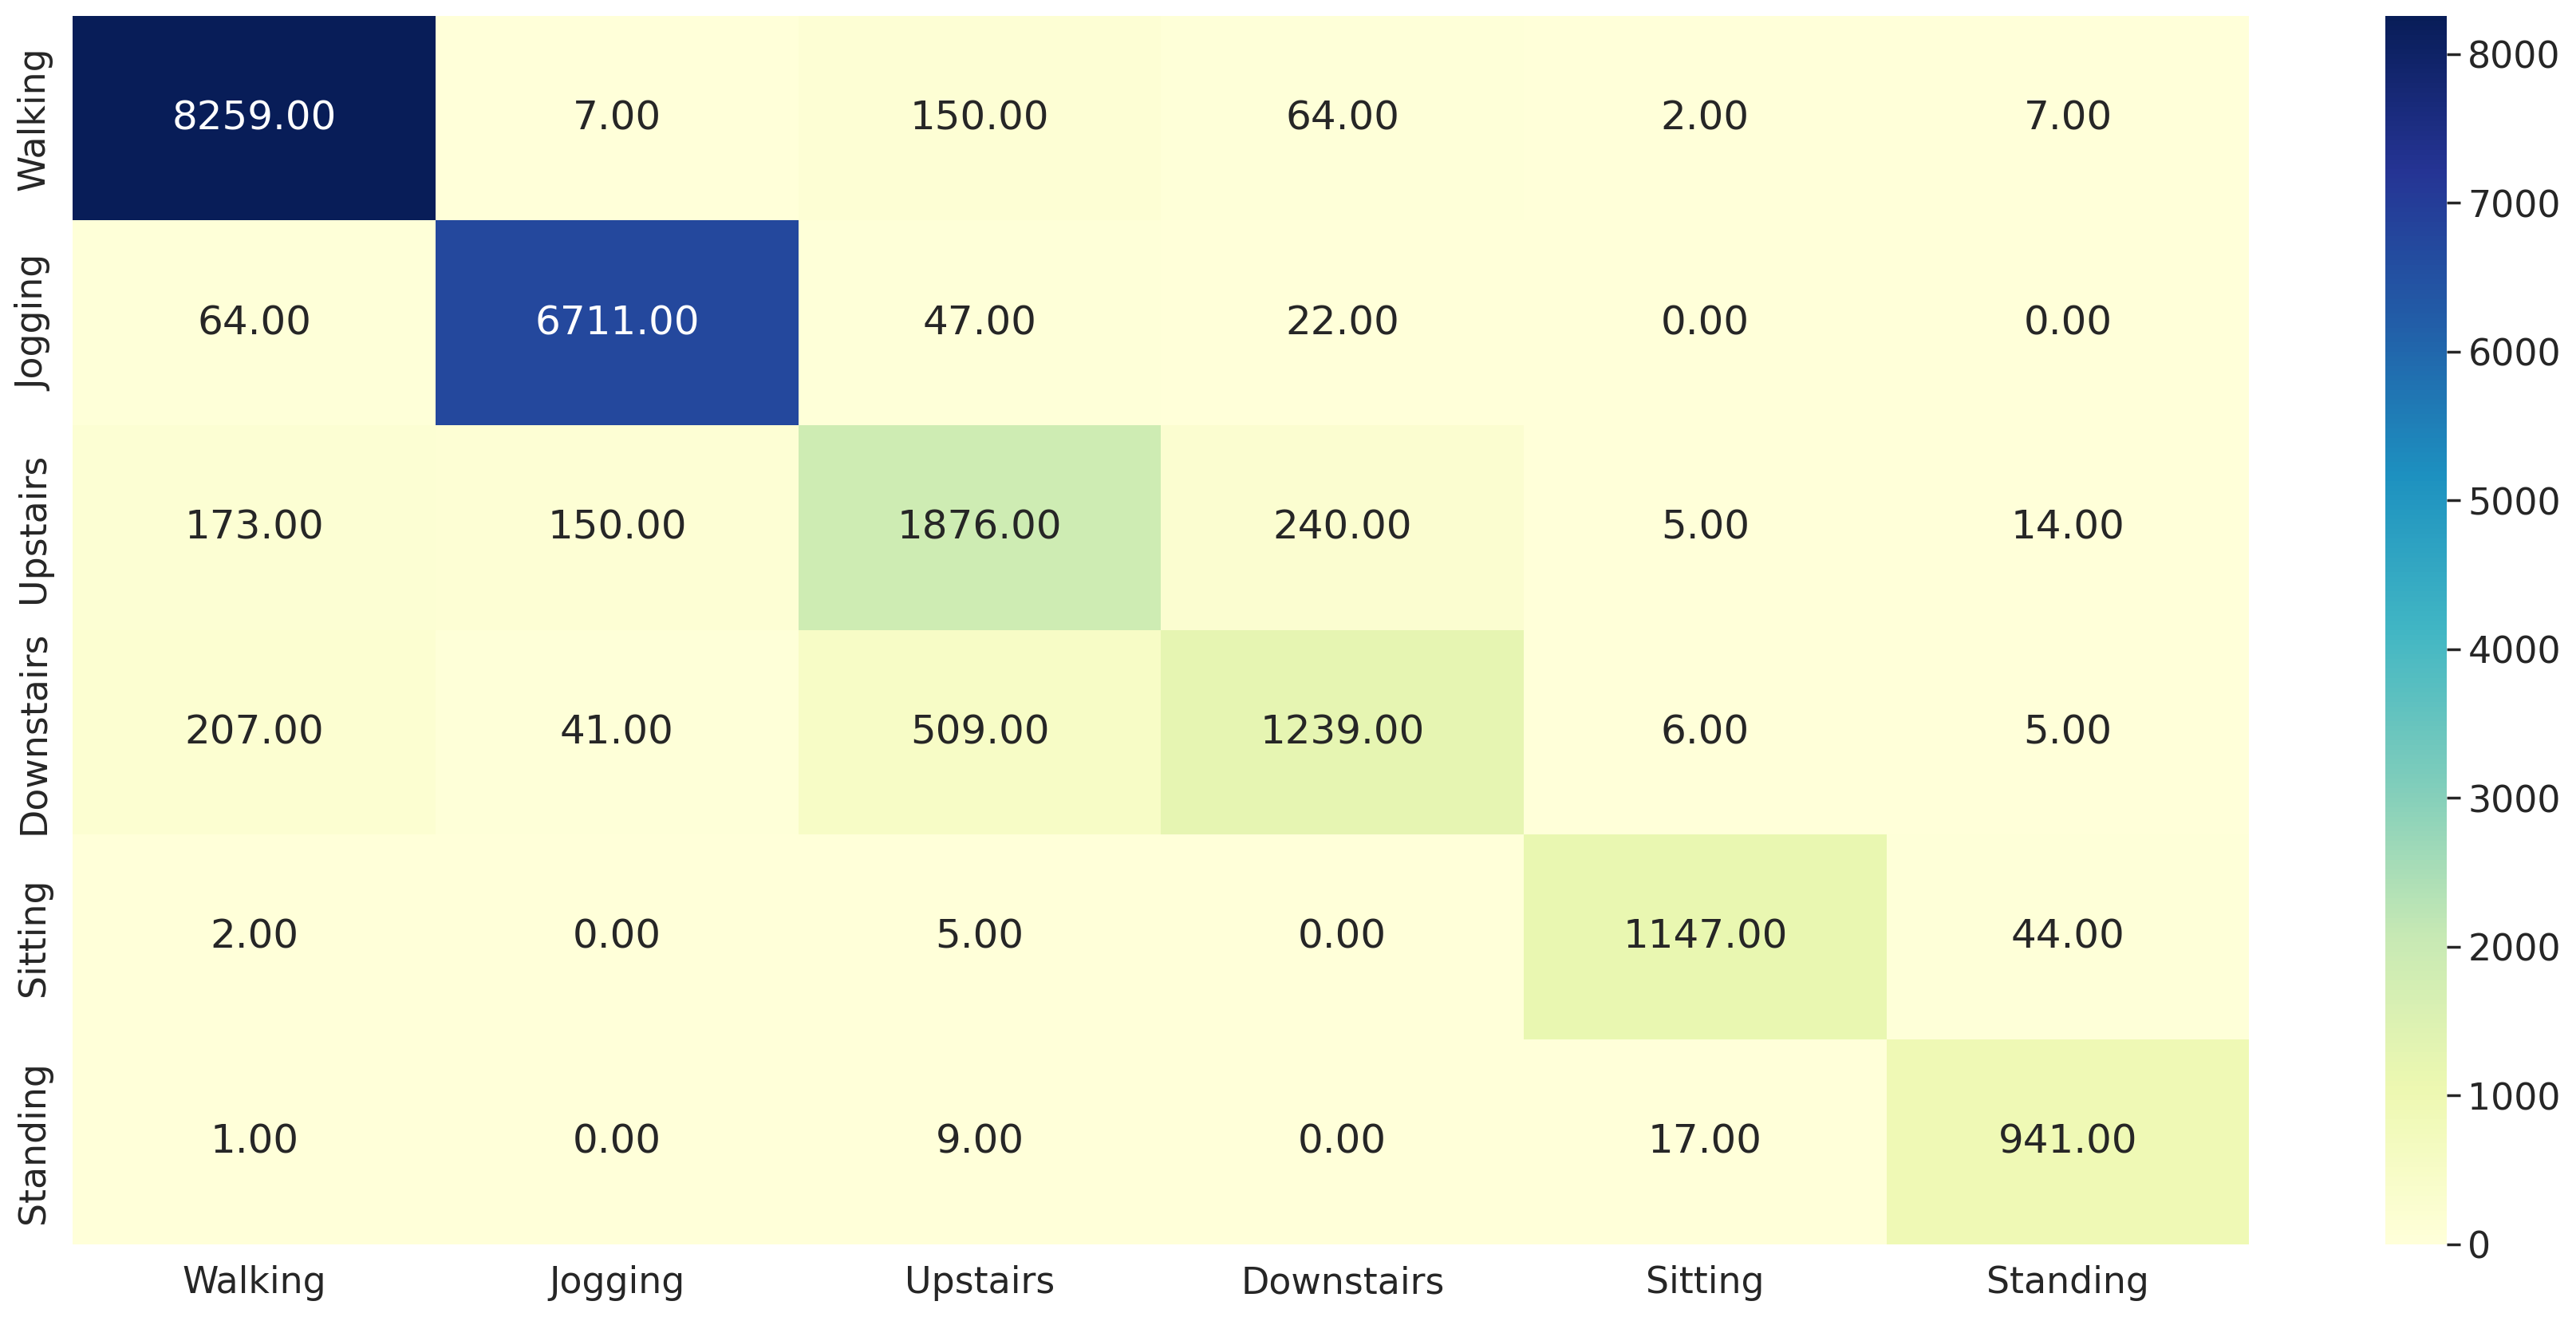

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU2

In [16]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 158790 (620.27 KB)
Trainable params: 158

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 11s 13ms/step - loss: 0.6062 - accuracy: 0.7868 - val_loss: 0.3162 - val_accuracy: 0.8884
Epoch 2/10
550/550 [==============================] - 6s 10ms/step - loss: 0.2569 - accuracy: 0.9130 - val_loss: 0.1849 - val_accuracy: 0.9389
Epoch 3/10
550/550 [==============================] - 5s 9ms/step - loss: 0.1729 - accuracy: 0.9454 - val_loss: 0.1584 - val_accuracy: 0.9515
Epoch 4/10
550/550 [==============================] - 7s 13ms/step - loss: 0.1276 - accuracy: 0.9602 - val_loss: 0.1093 - val_accuracy: 0.9639
Epoch 5/10
550/550 [==============================] - 6s 11ms/step - loss: 0.0986 - accuracy: 0.9695 - val_loss: 0.0916 - val_accuracy: 0.9707
Epoch 6/10
550/550 [==============================] - 6s 12ms/step - loss: 0.0813 - accuracy: 0.9739 - val_loss: 0.0774 - val_accuracy: 0.9754
Epoch 7/10
550/550 [==============================] - 6s 10ms/step - loss: 0.0671 - accuracy: 0.9792 - val_loss: 0.0722 - val_accuracy: 0.9791

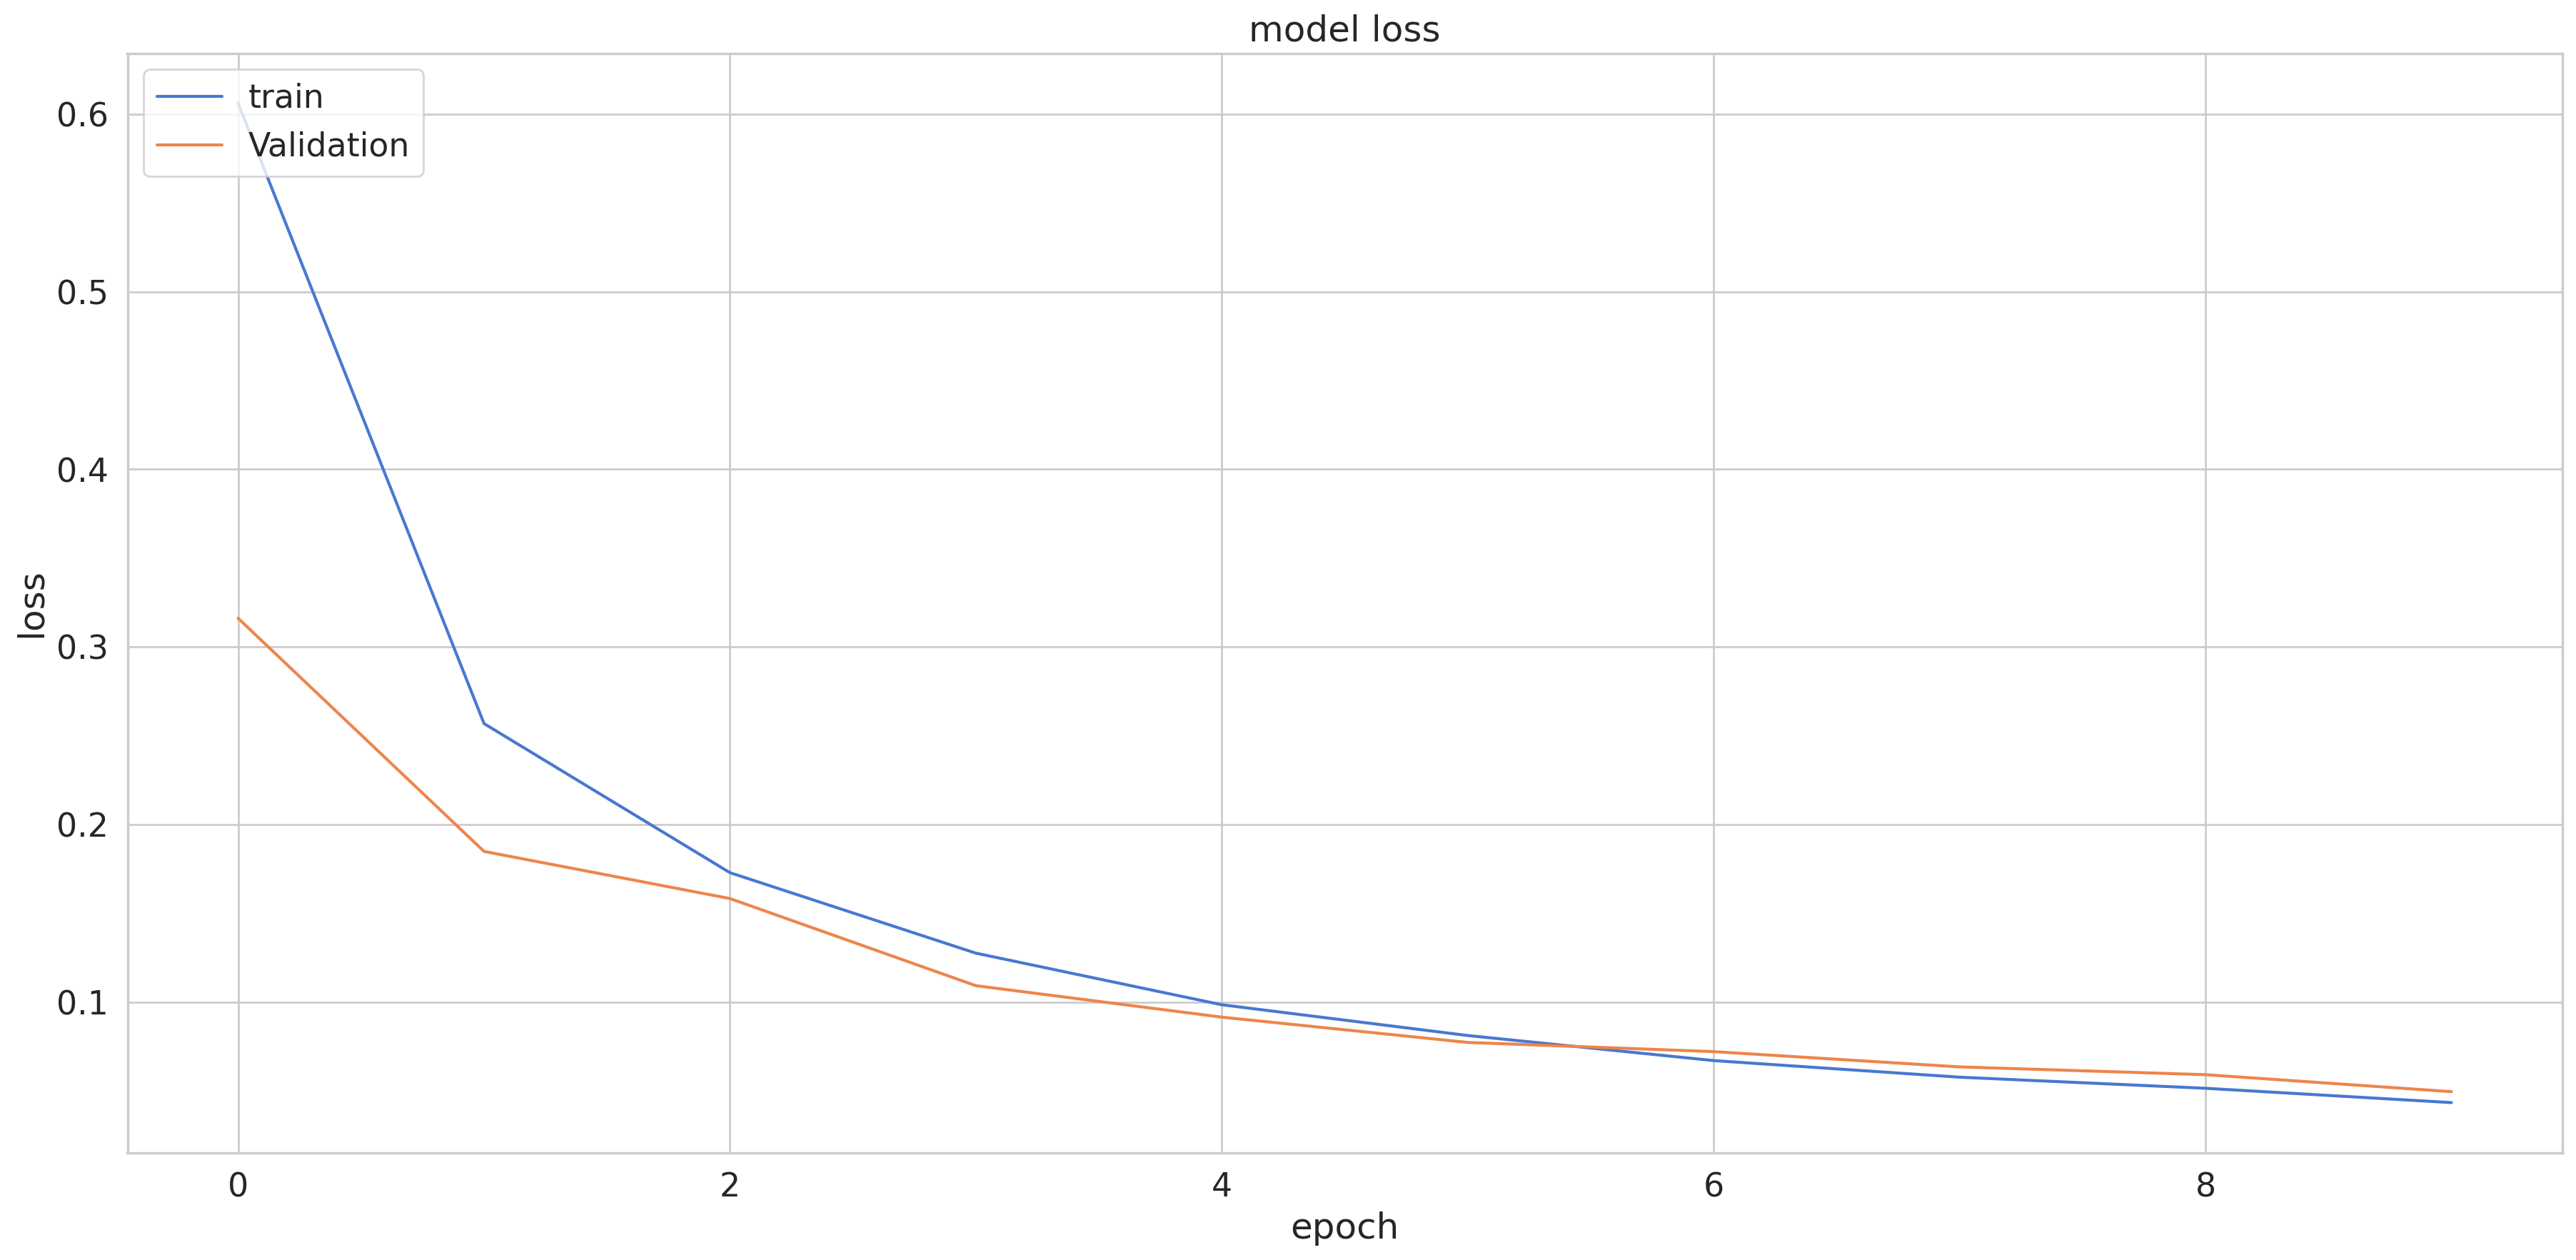

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

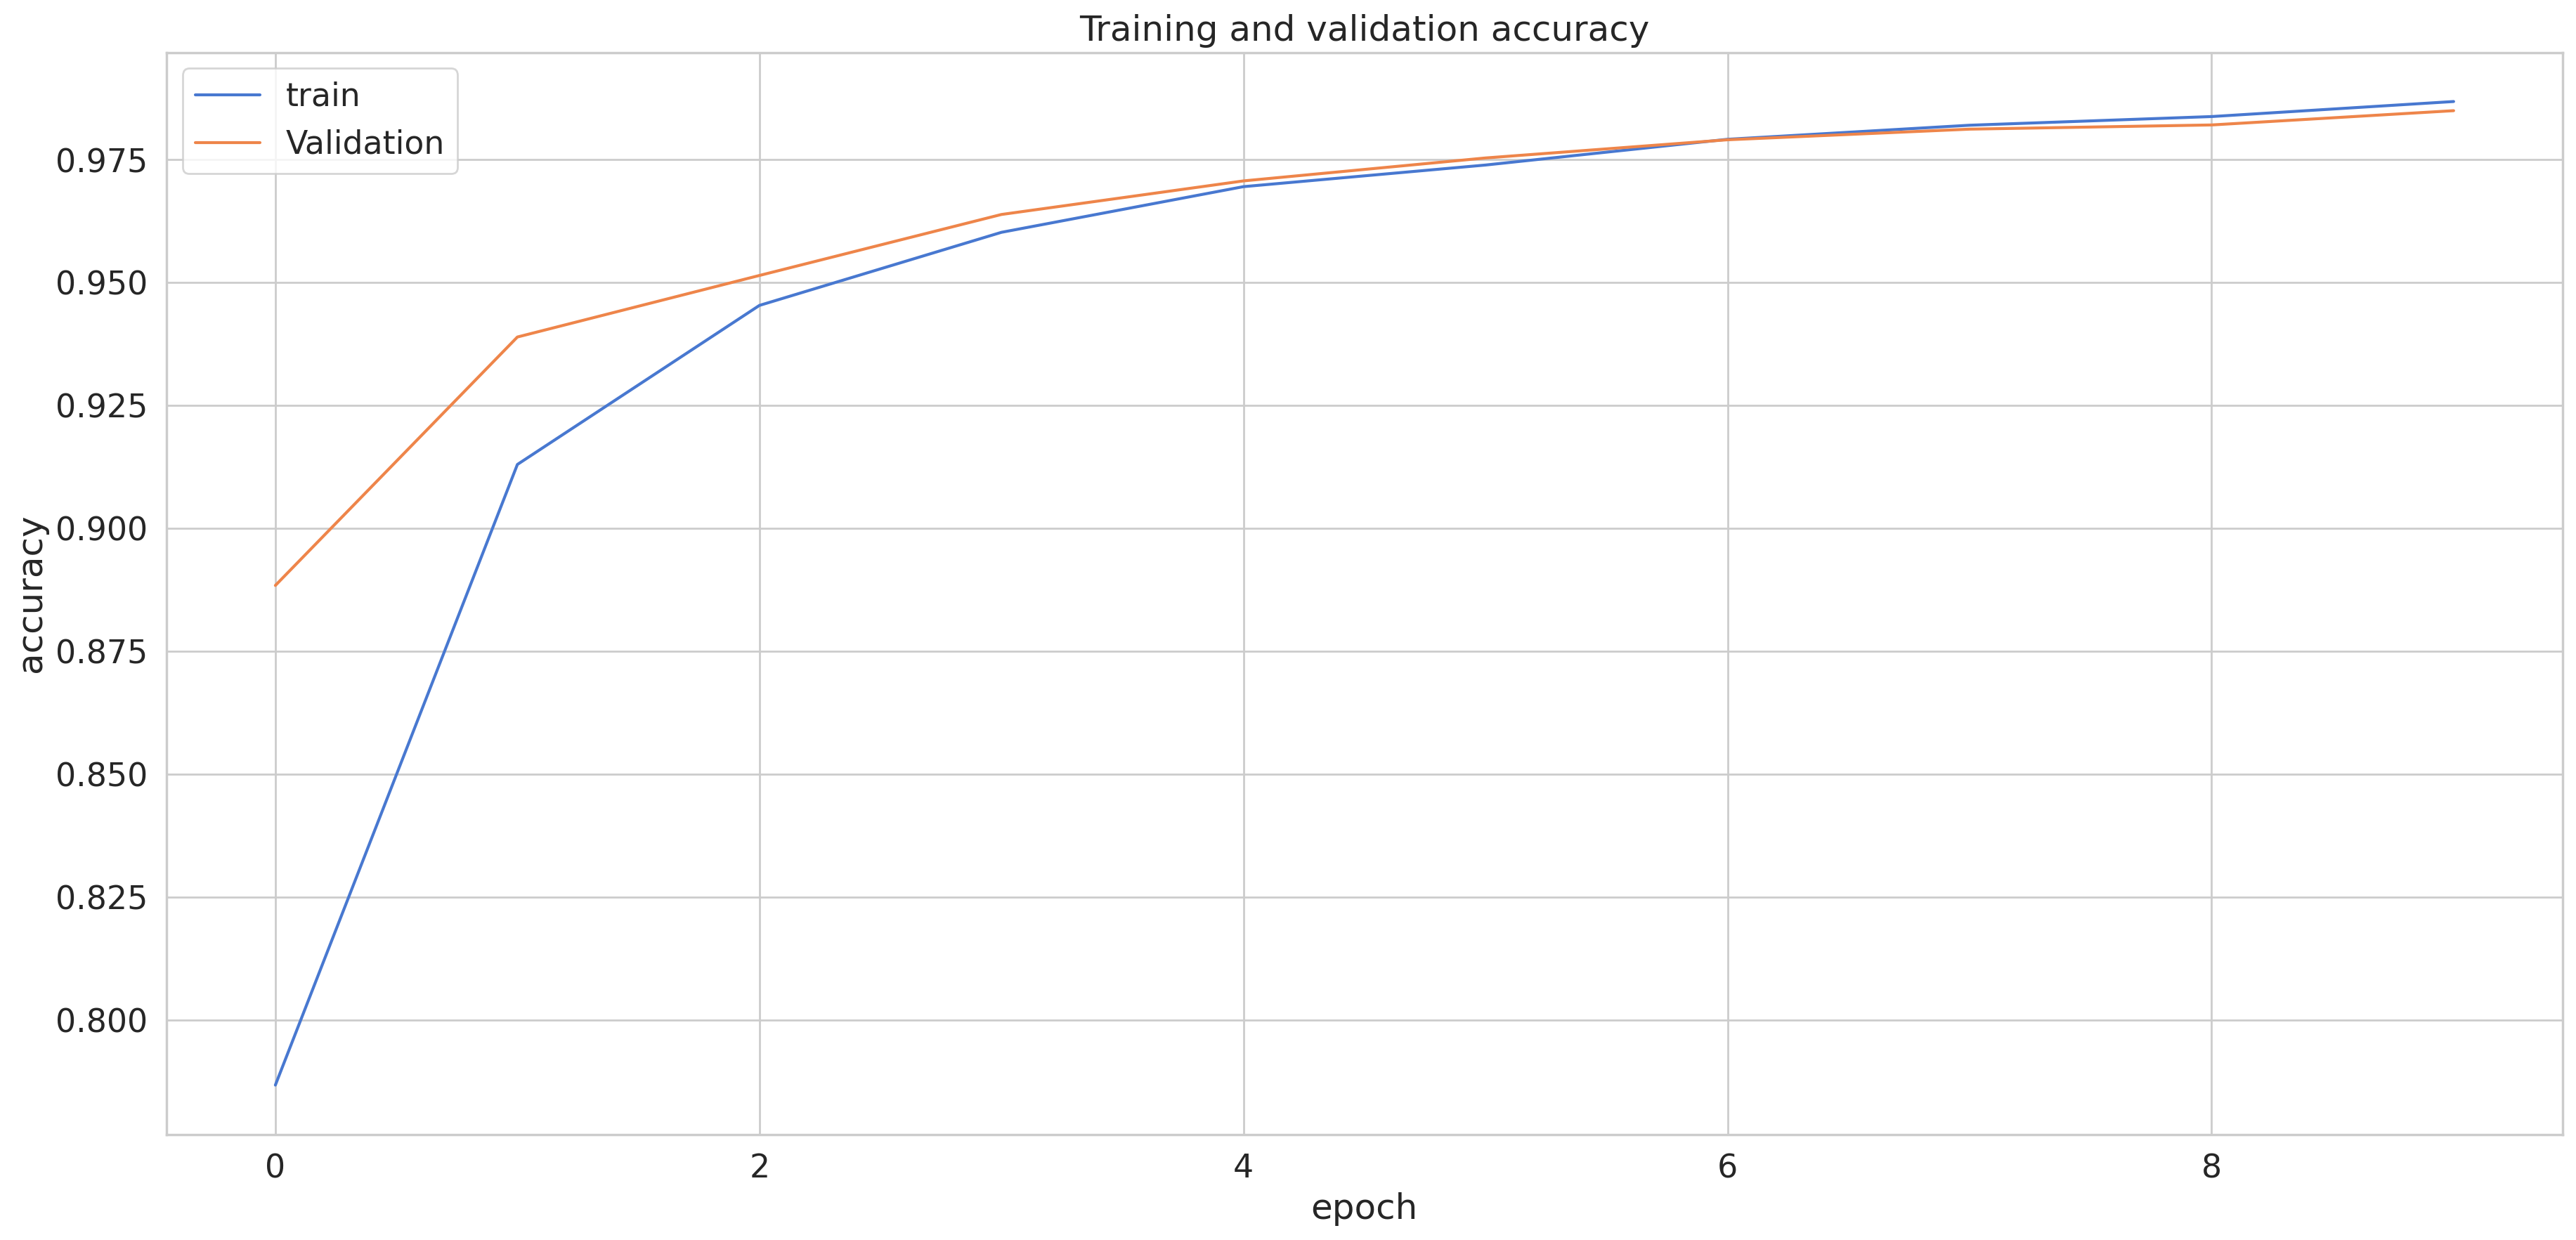

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 3s 3ms/step
f1_score =  0.9855446203082552
0.9855217628847205
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.96      0.95      0.96      2458
           3       0.95      0.97      0.96      2007
           4       0.99      0.99      0.99      1198
           5       0.99      0.98      0.98       968

    accuracy                           0.99     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

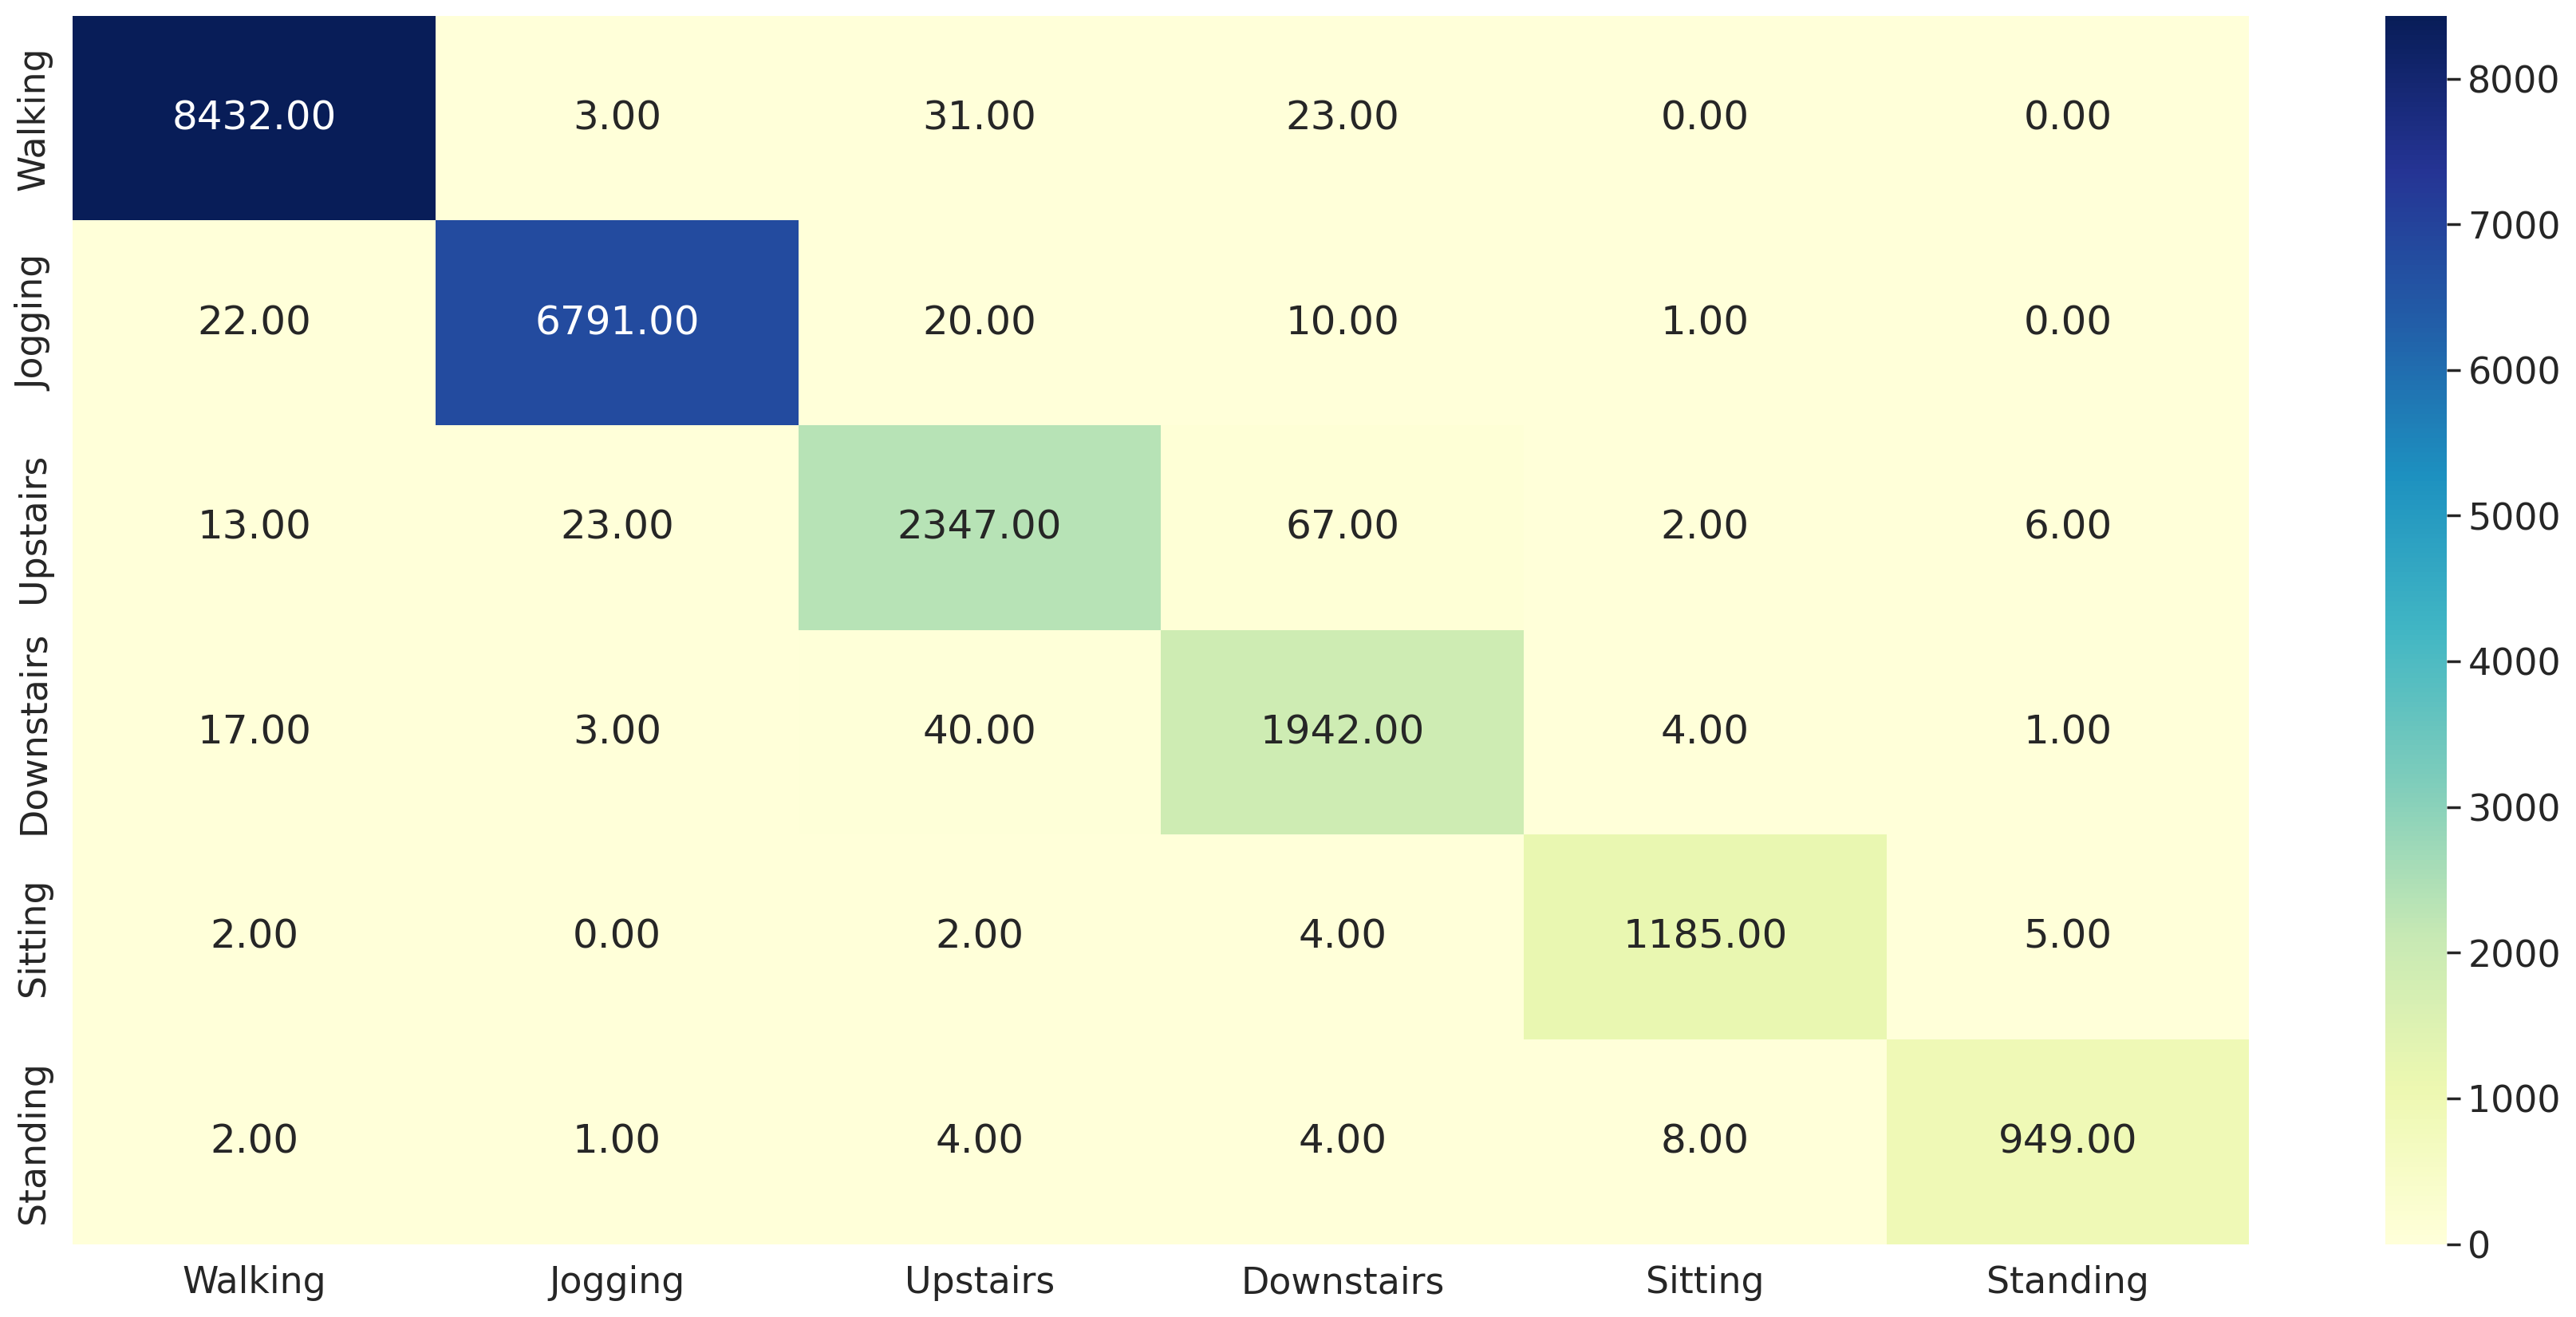

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU3

In [21]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_5 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 15s 16ms/step - loss: 0.5788 - accuracy: 0.7956 - val_loss: 0.2966 - val_accuracy: 0.8963
Epoch 2/10
550/550 [==============================] - 8s 14ms/step - loss: 0.2320 - accuracy: 0.9214 - val_loss: 0.1673 - val_accuracy: 0.9475
Epoch 3/10
550/550 [==============================] - 8s 14ms/step - loss: 0.1492 - accuracy: 0.9524 - val_loss: 0.1121 - val_accuracy: 0.9646
Epoch 4/10
550/550 [==============================] - 9s 16ms/step - loss: 0.1114 - accuracy: 0.9646 - val_loss: 0.0879 - val_accuracy: 0.9722
Epoch 5/10
550/550 [==============================] - 10s 17ms/step - loss: 0.0848 - accuracy: 0.9732 - val_loss: 0.0791 - val_accuracy: 0.9763
Epoch 6/10
550/550 [==============================] - 8s 14ms/step - loss: 0.0728 - accuracy: 0.9777 - val_loss: 0.0669 - val_accuracy: 0.9807
Epoch 7/10
550/550 [==============================] - 8s 14ms/step - loss: 0.0617 - accuracy: 0.9814 - val_loss: 0.0574 - val_accuracy: 0.98

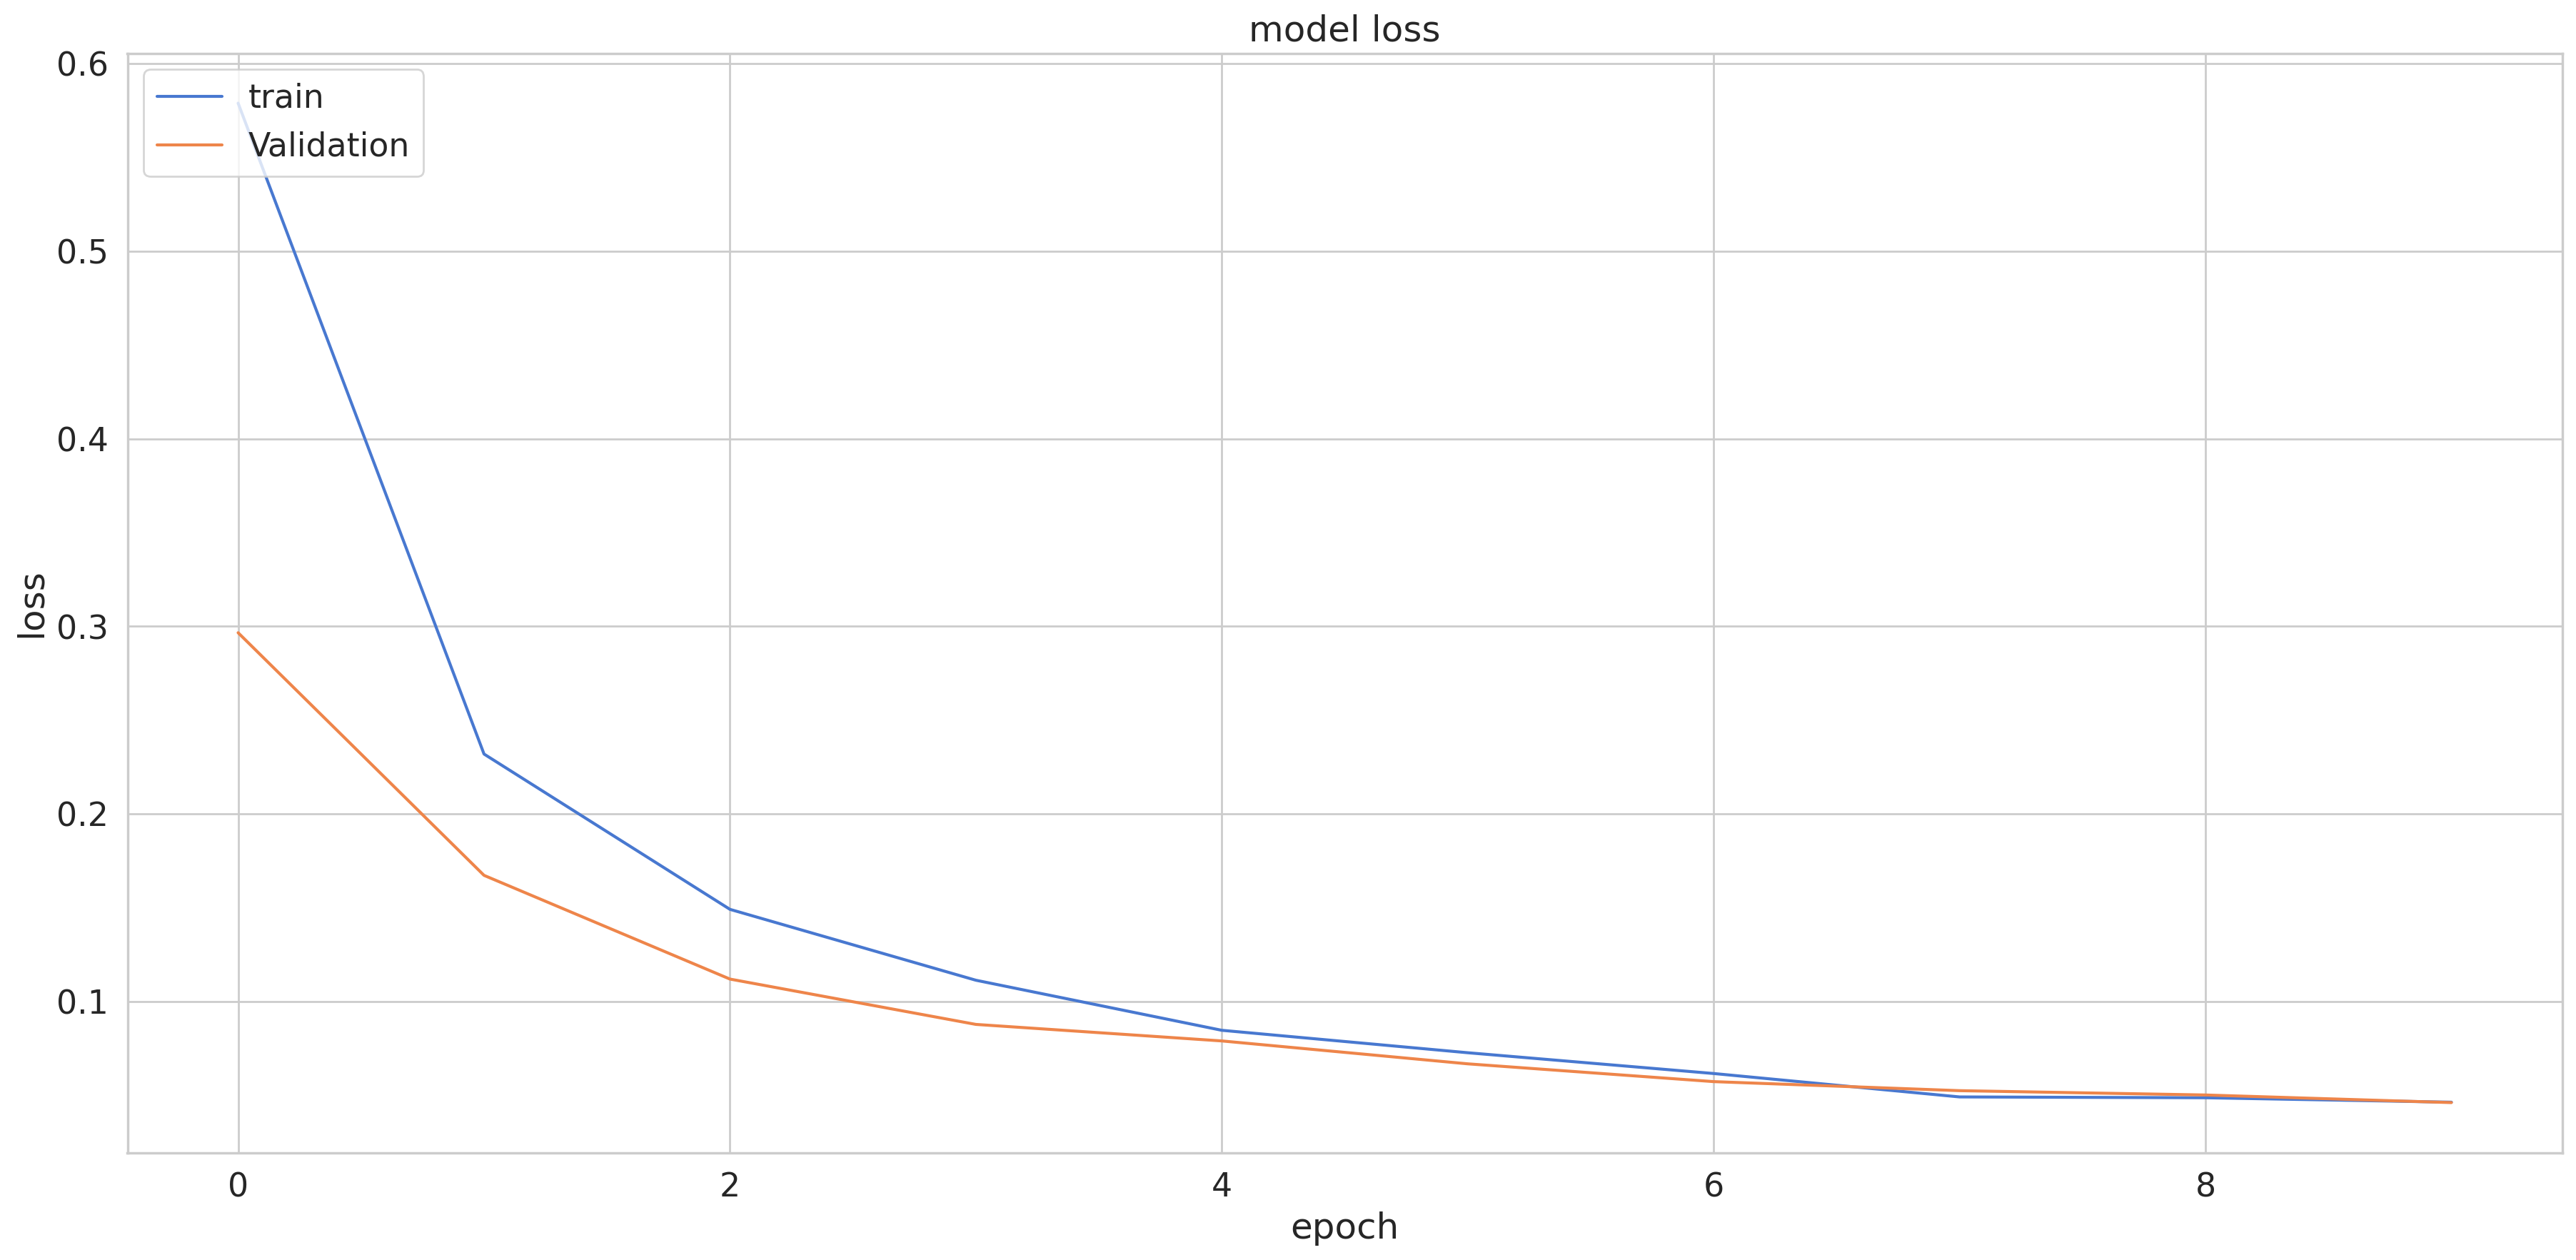

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

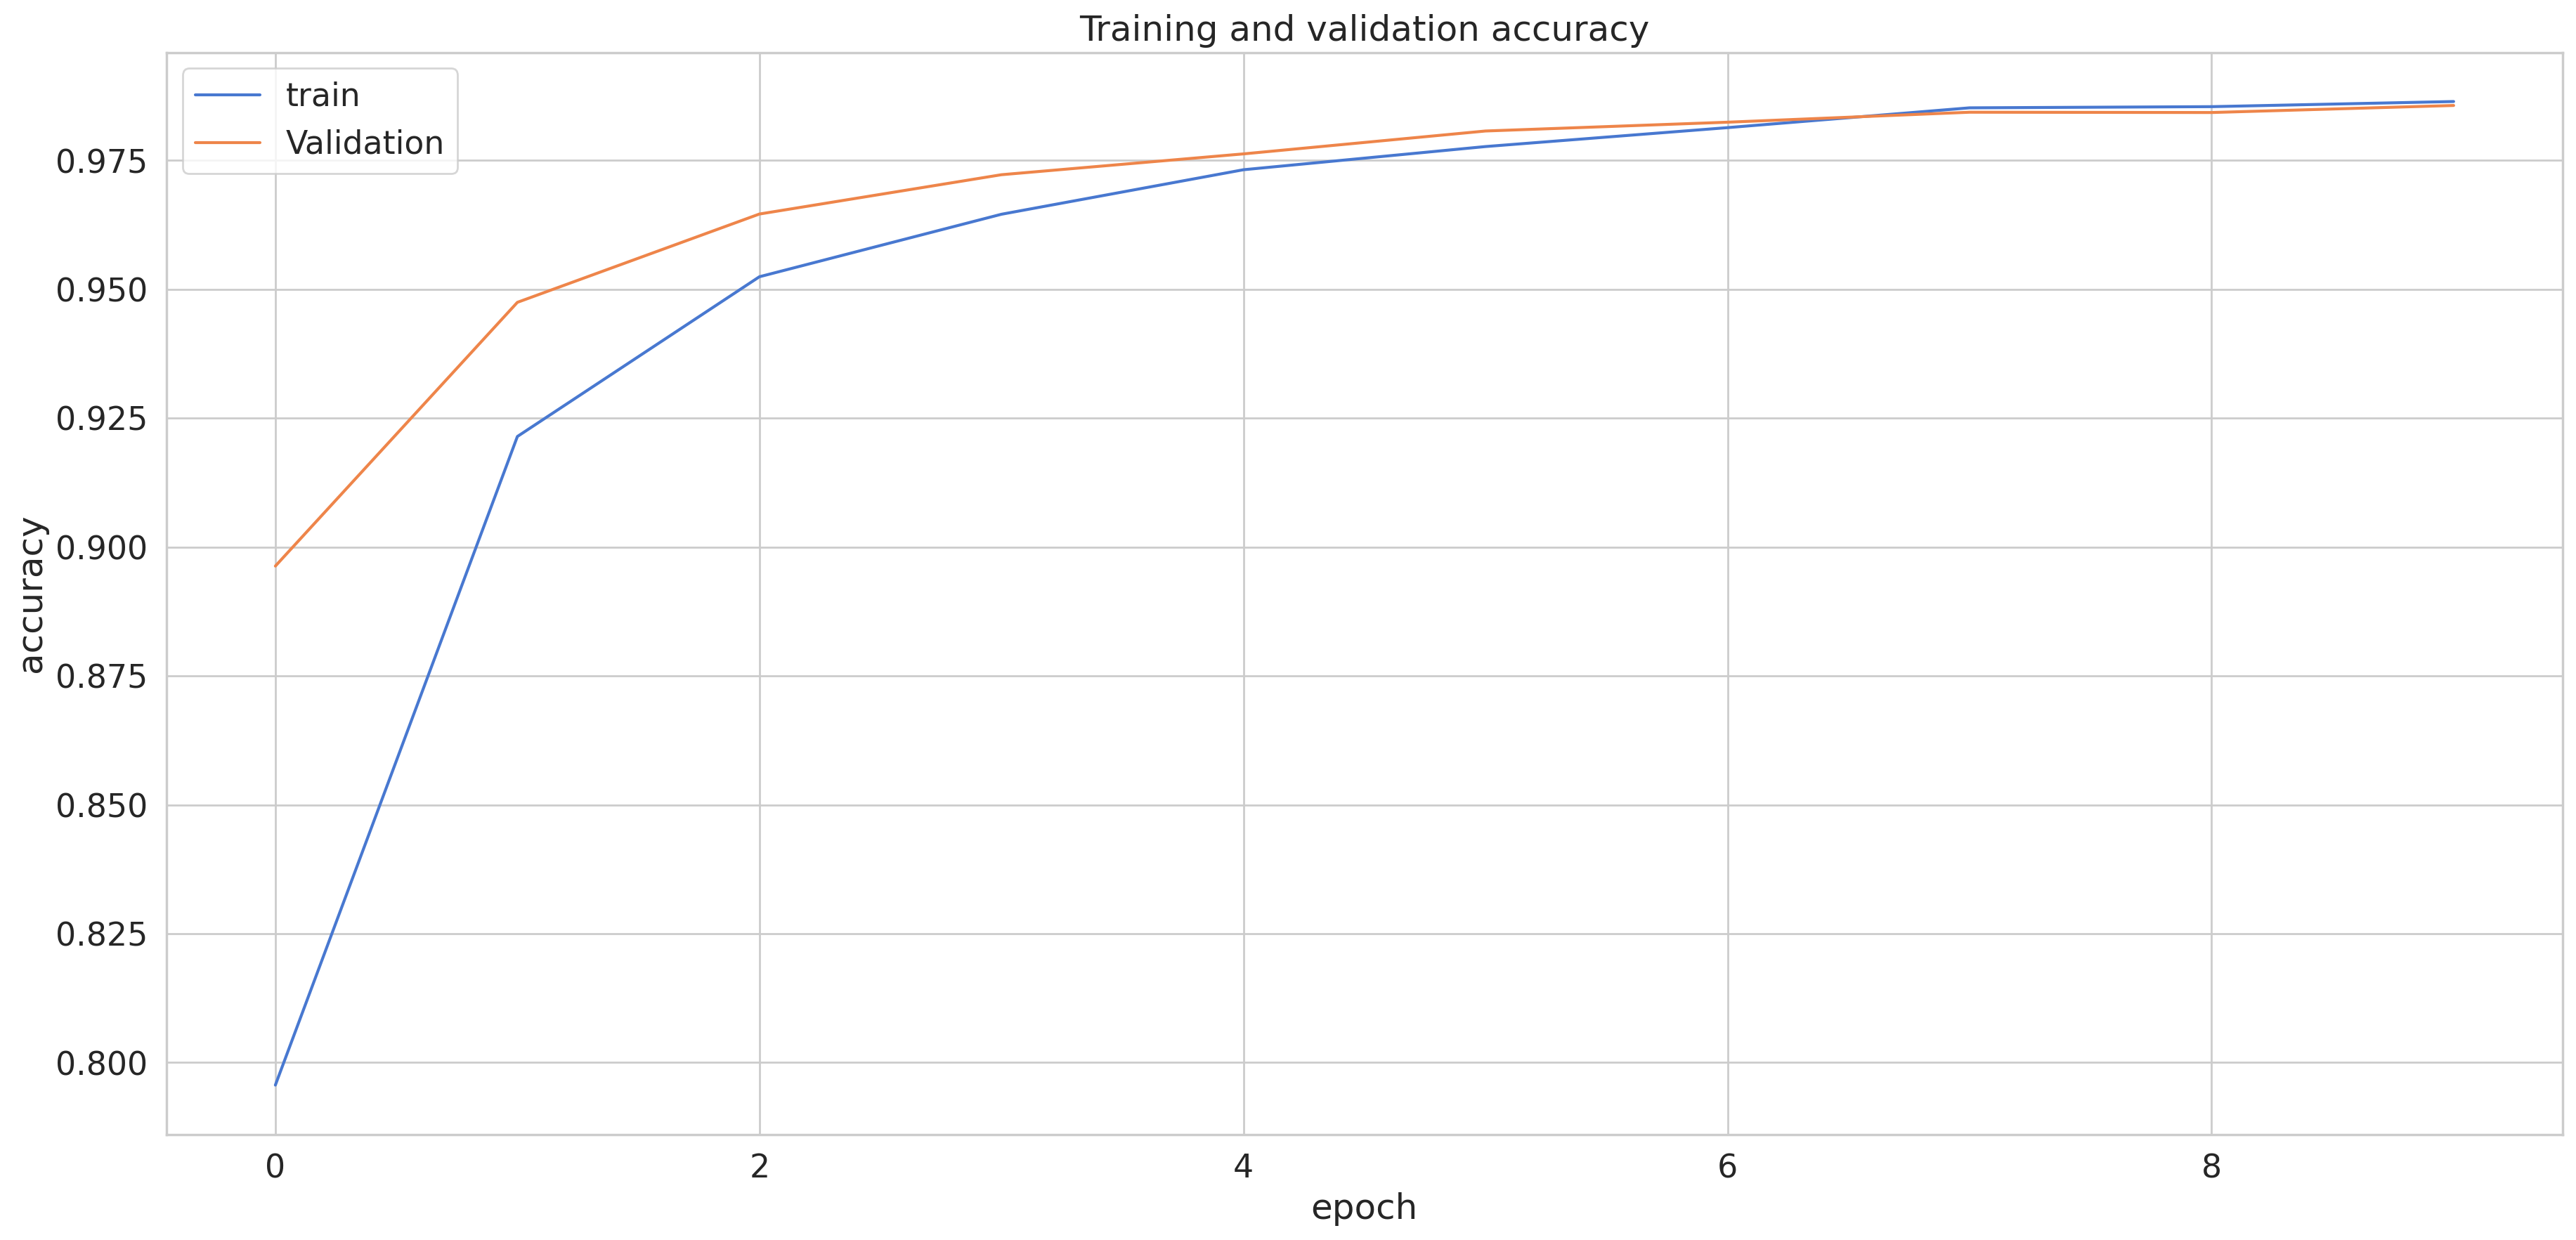

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 5s 5ms/step
f1_score =  0.9856145286822255
0.9856128209797851
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.97      0.95      0.96      2458
           3       0.95      0.98      0.96      2007
           4       0.96      0.99      0.98      1198
           5       0.98      0.95      0.97       968

    accuracy                           0.99     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.99      0.99      0.99     21964



<Axes: >

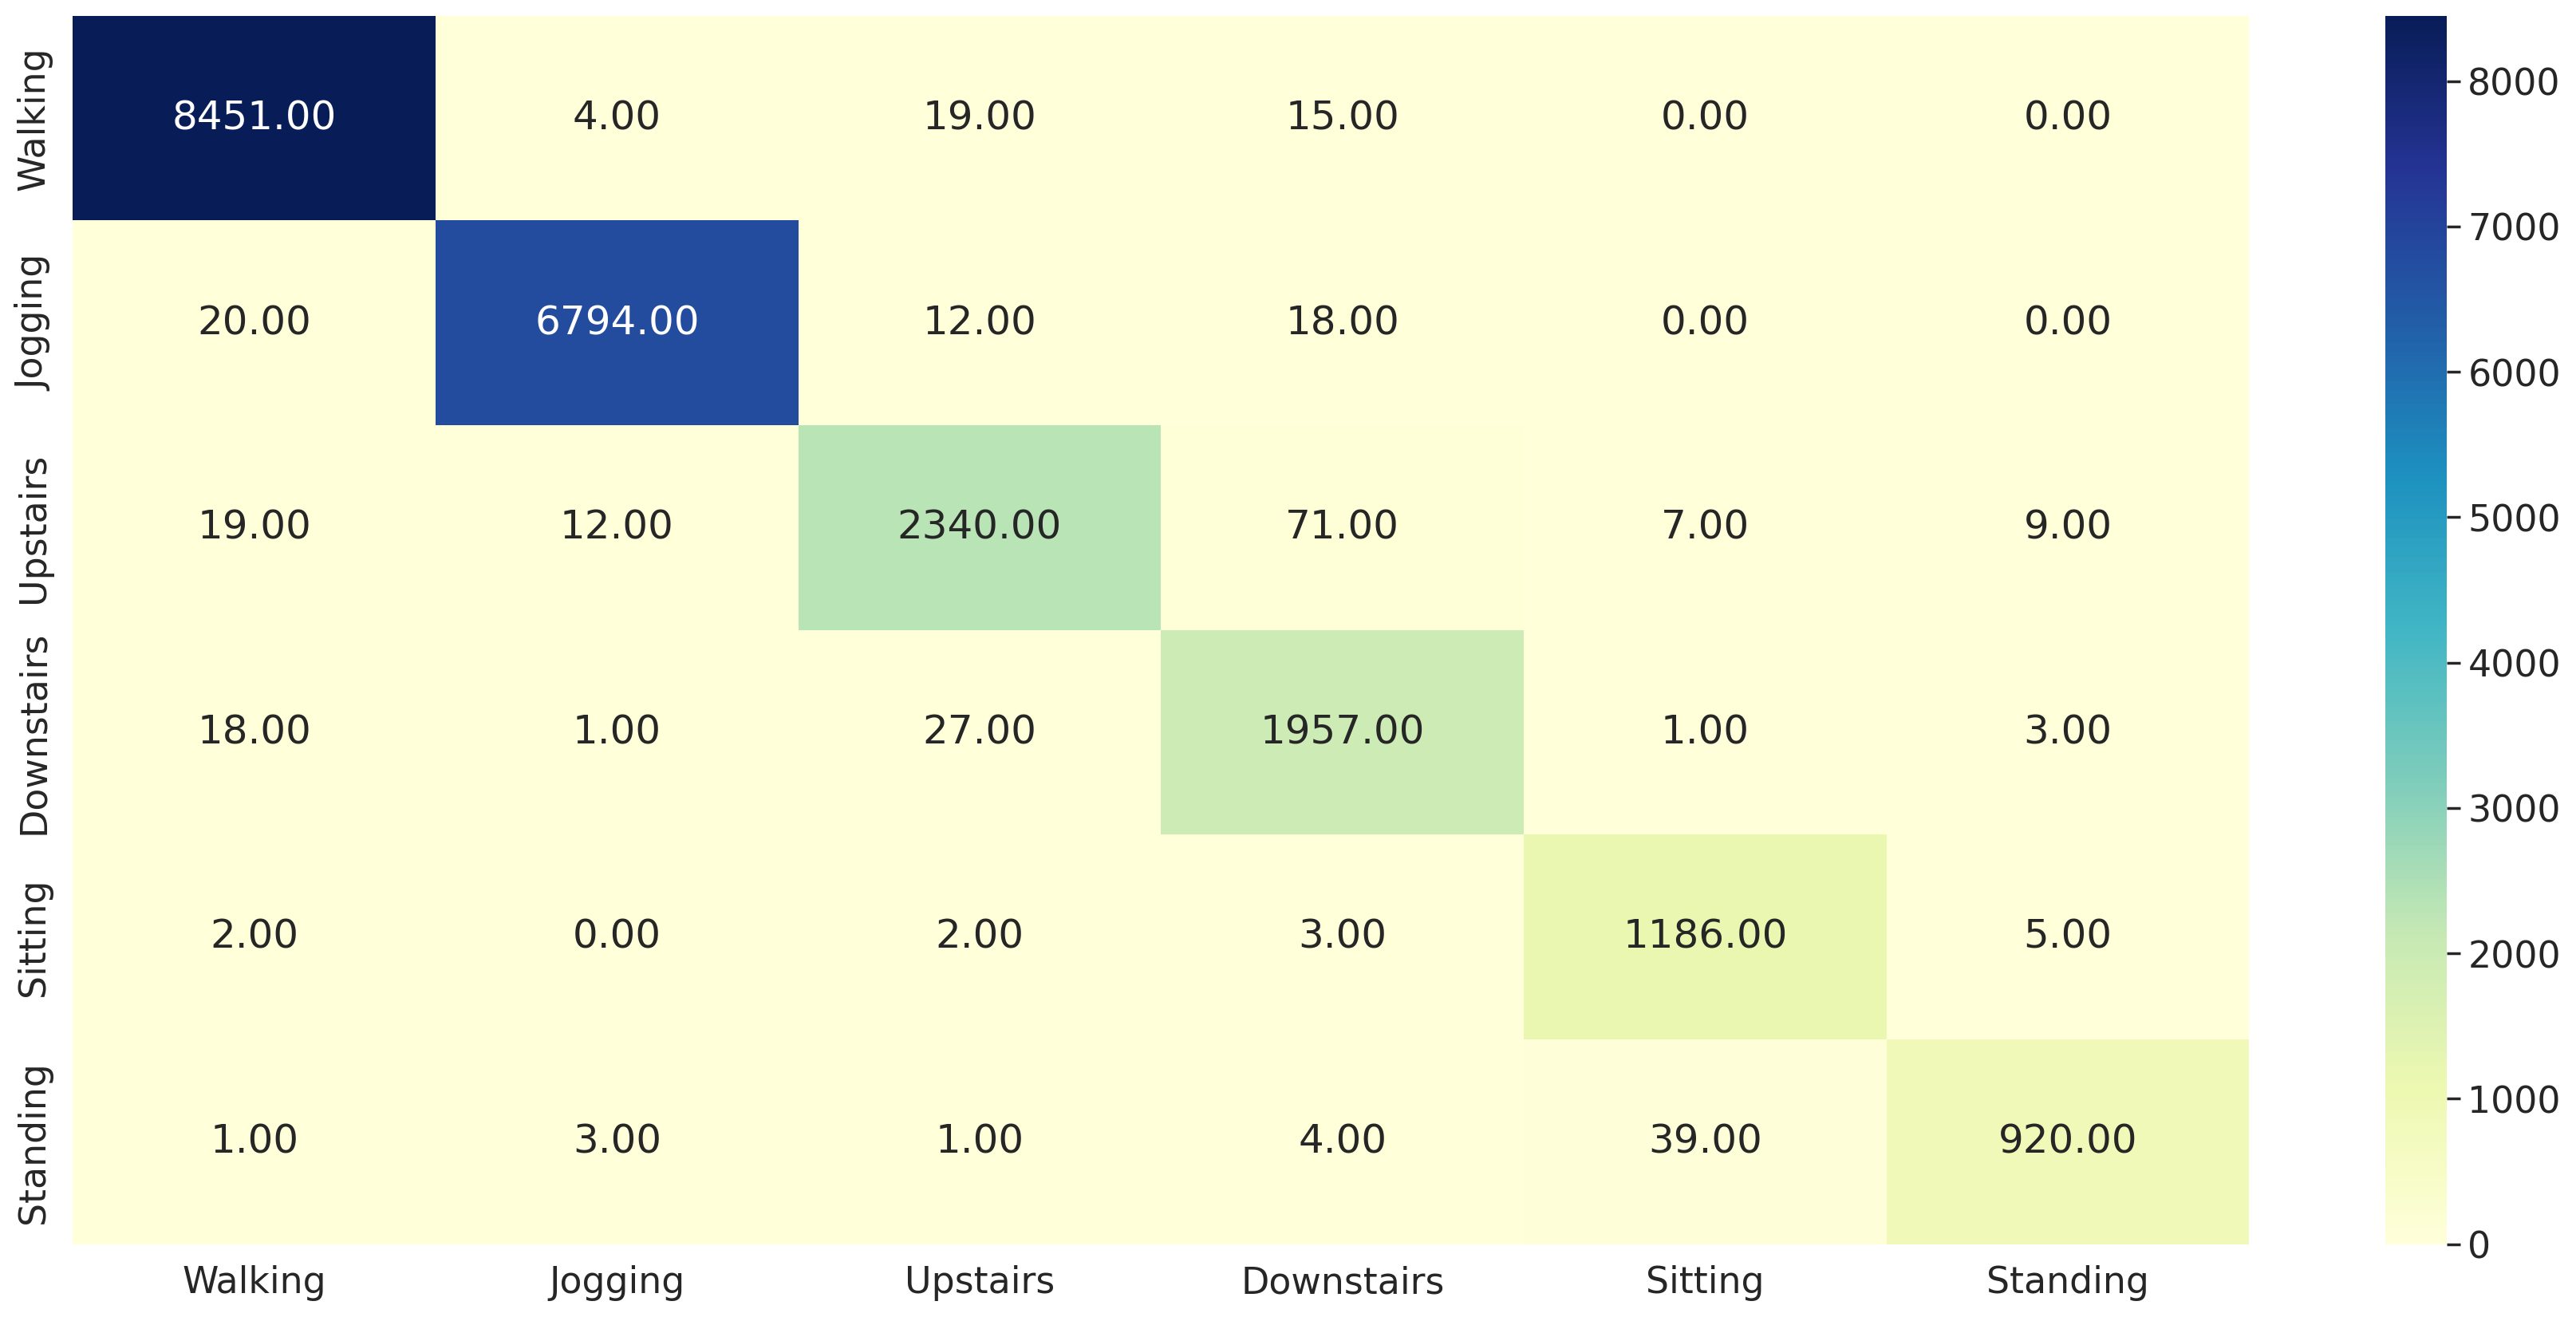

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU4

In [26]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50, 128)           51072     
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_7 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 50, 128)           99072     
                                                                 
 dropout_9 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 19s 21ms/step - loss: 0.5620 - accuracy: 0.8016 - val_loss: 0.2819 - val_accuracy: 0.9043
Epoch 2/10
550/550 [==============================] - 10s 18ms/step - loss: 0.2239 - accuracy: 0.9267 - val_loss: 0.1659 - val_accuracy: 0.9486
Epoch 3/10
550/550 [==============================] - 10s 17ms/step - loss: 0.1486 - accuracy: 0.9527 - val_loss: 0.1289 - val_accuracy: 0.9602
Epoch 4/10
550/550 [==============================] - 10s 18ms/step - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.0873 - val_accuracy: 0.9740
Epoch 5/10
550/550 [==============================] - 10s 18ms/step - loss: 0.0883 - accuracy: 0.9729 - val_loss: 0.0797 - val_accuracy: 0.9762
Epoch 6/10
550/550 [==============================] - 9s 17ms/step - loss: 0.0713 - accuracy: 0.9783 - val_loss: 0.0666 - val_accuracy: 0.9800
Epoch 7/10
550/550 [==============================] - 10s 18ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.0522 - val_accuracy: 

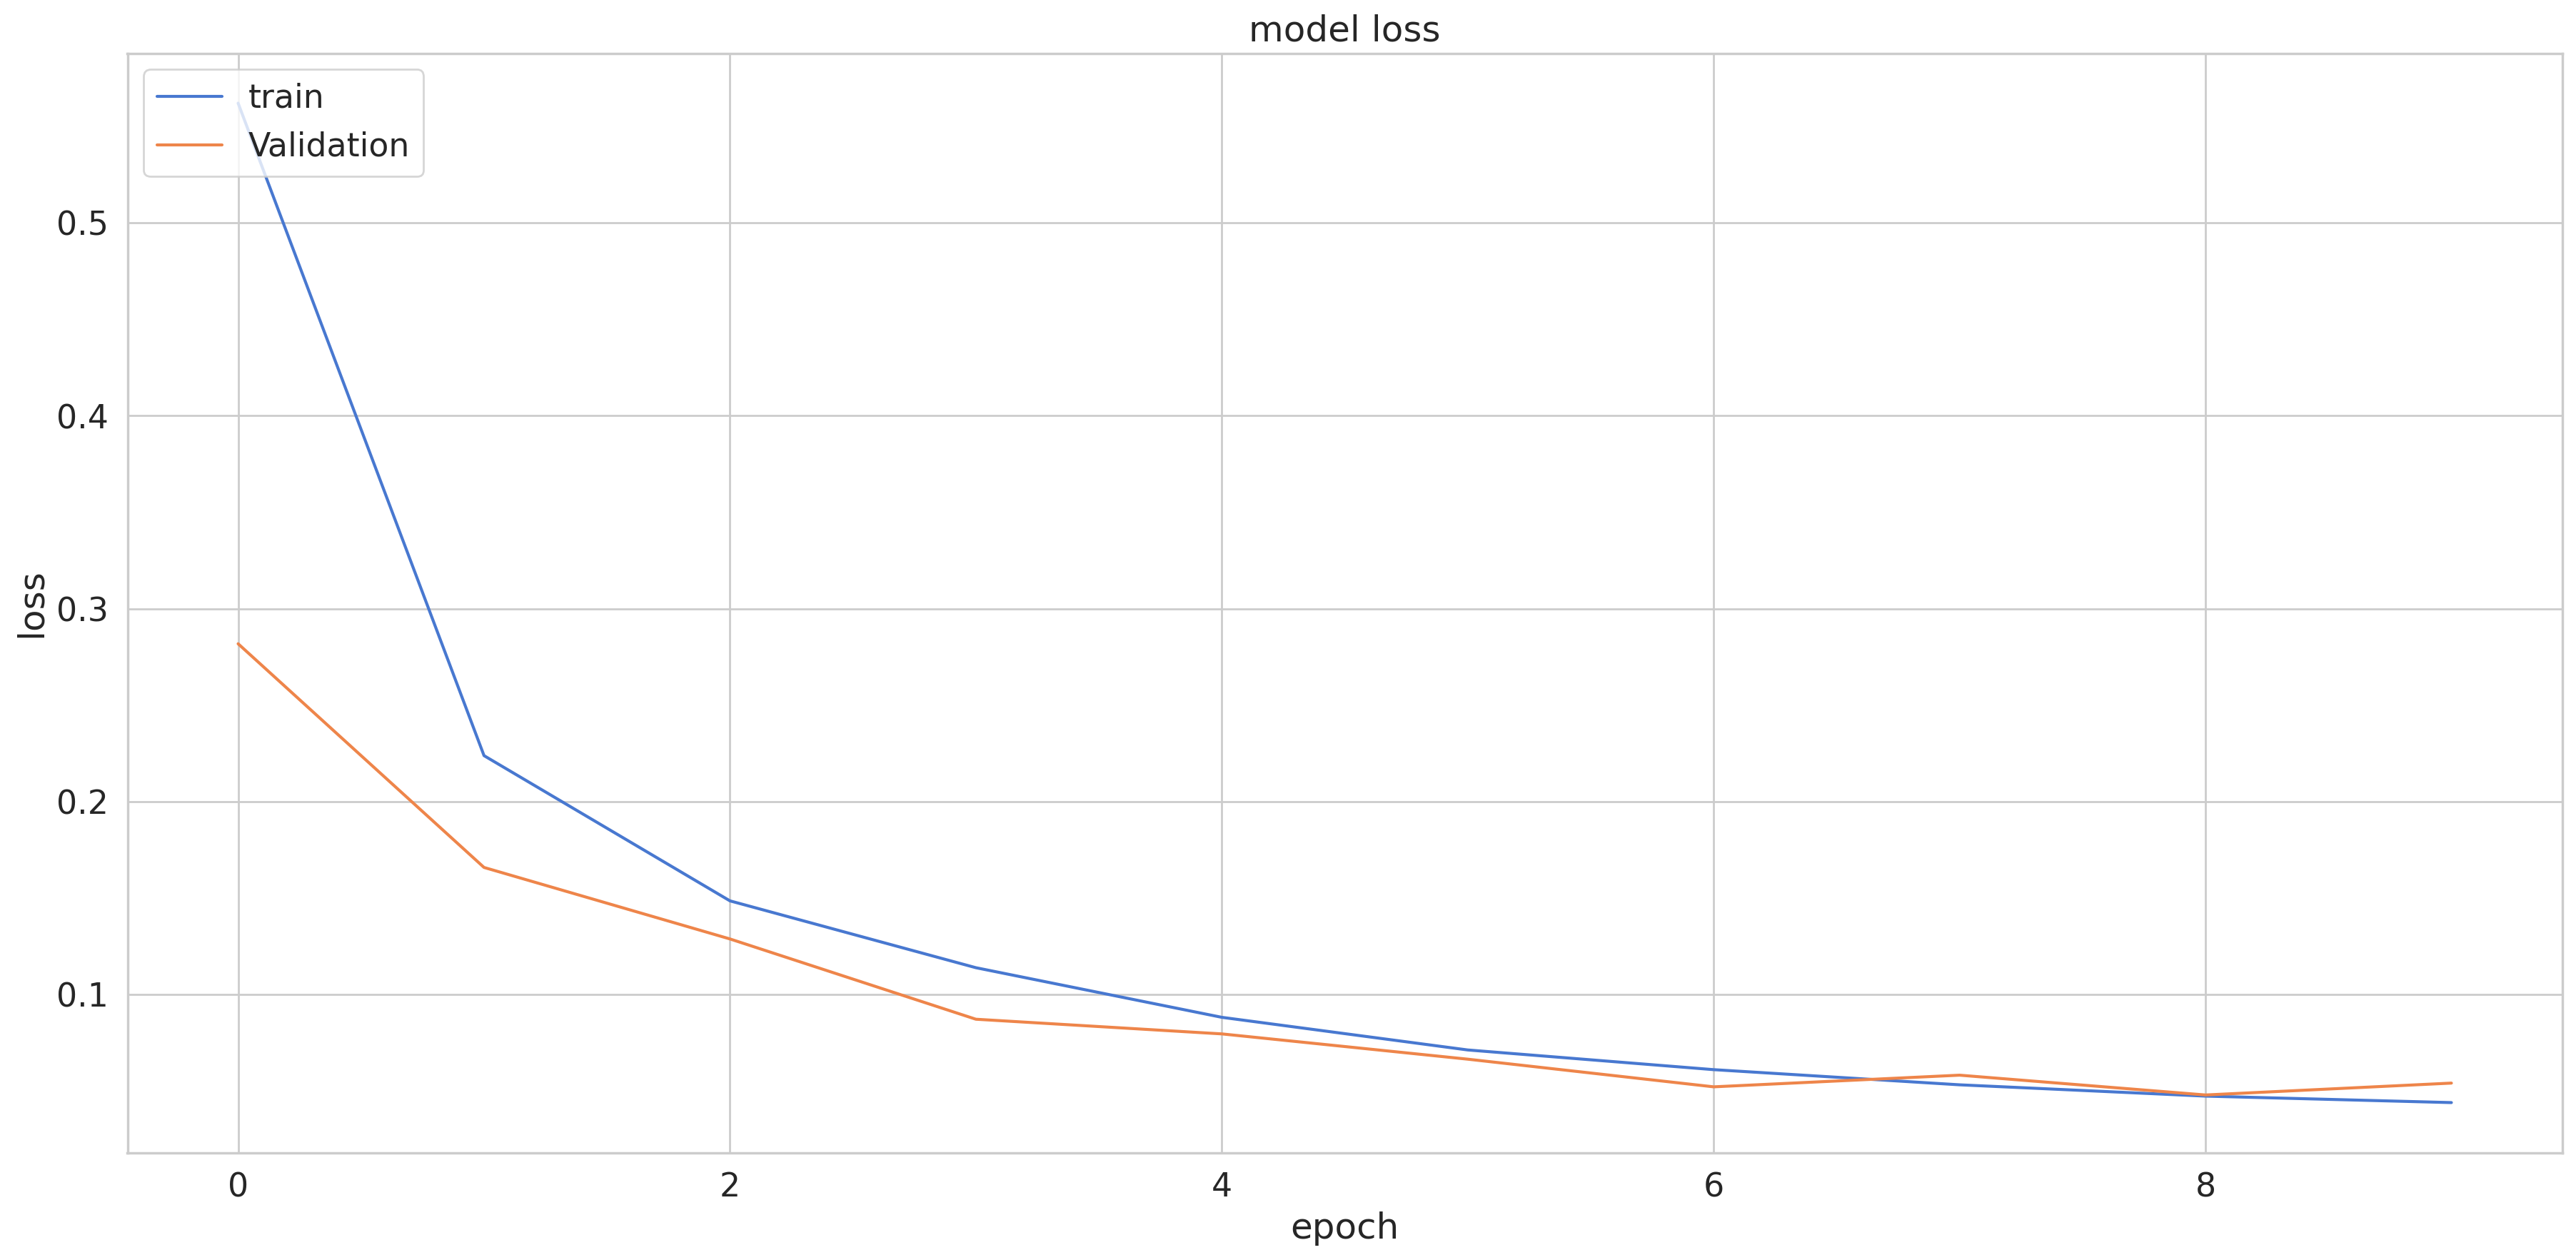

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

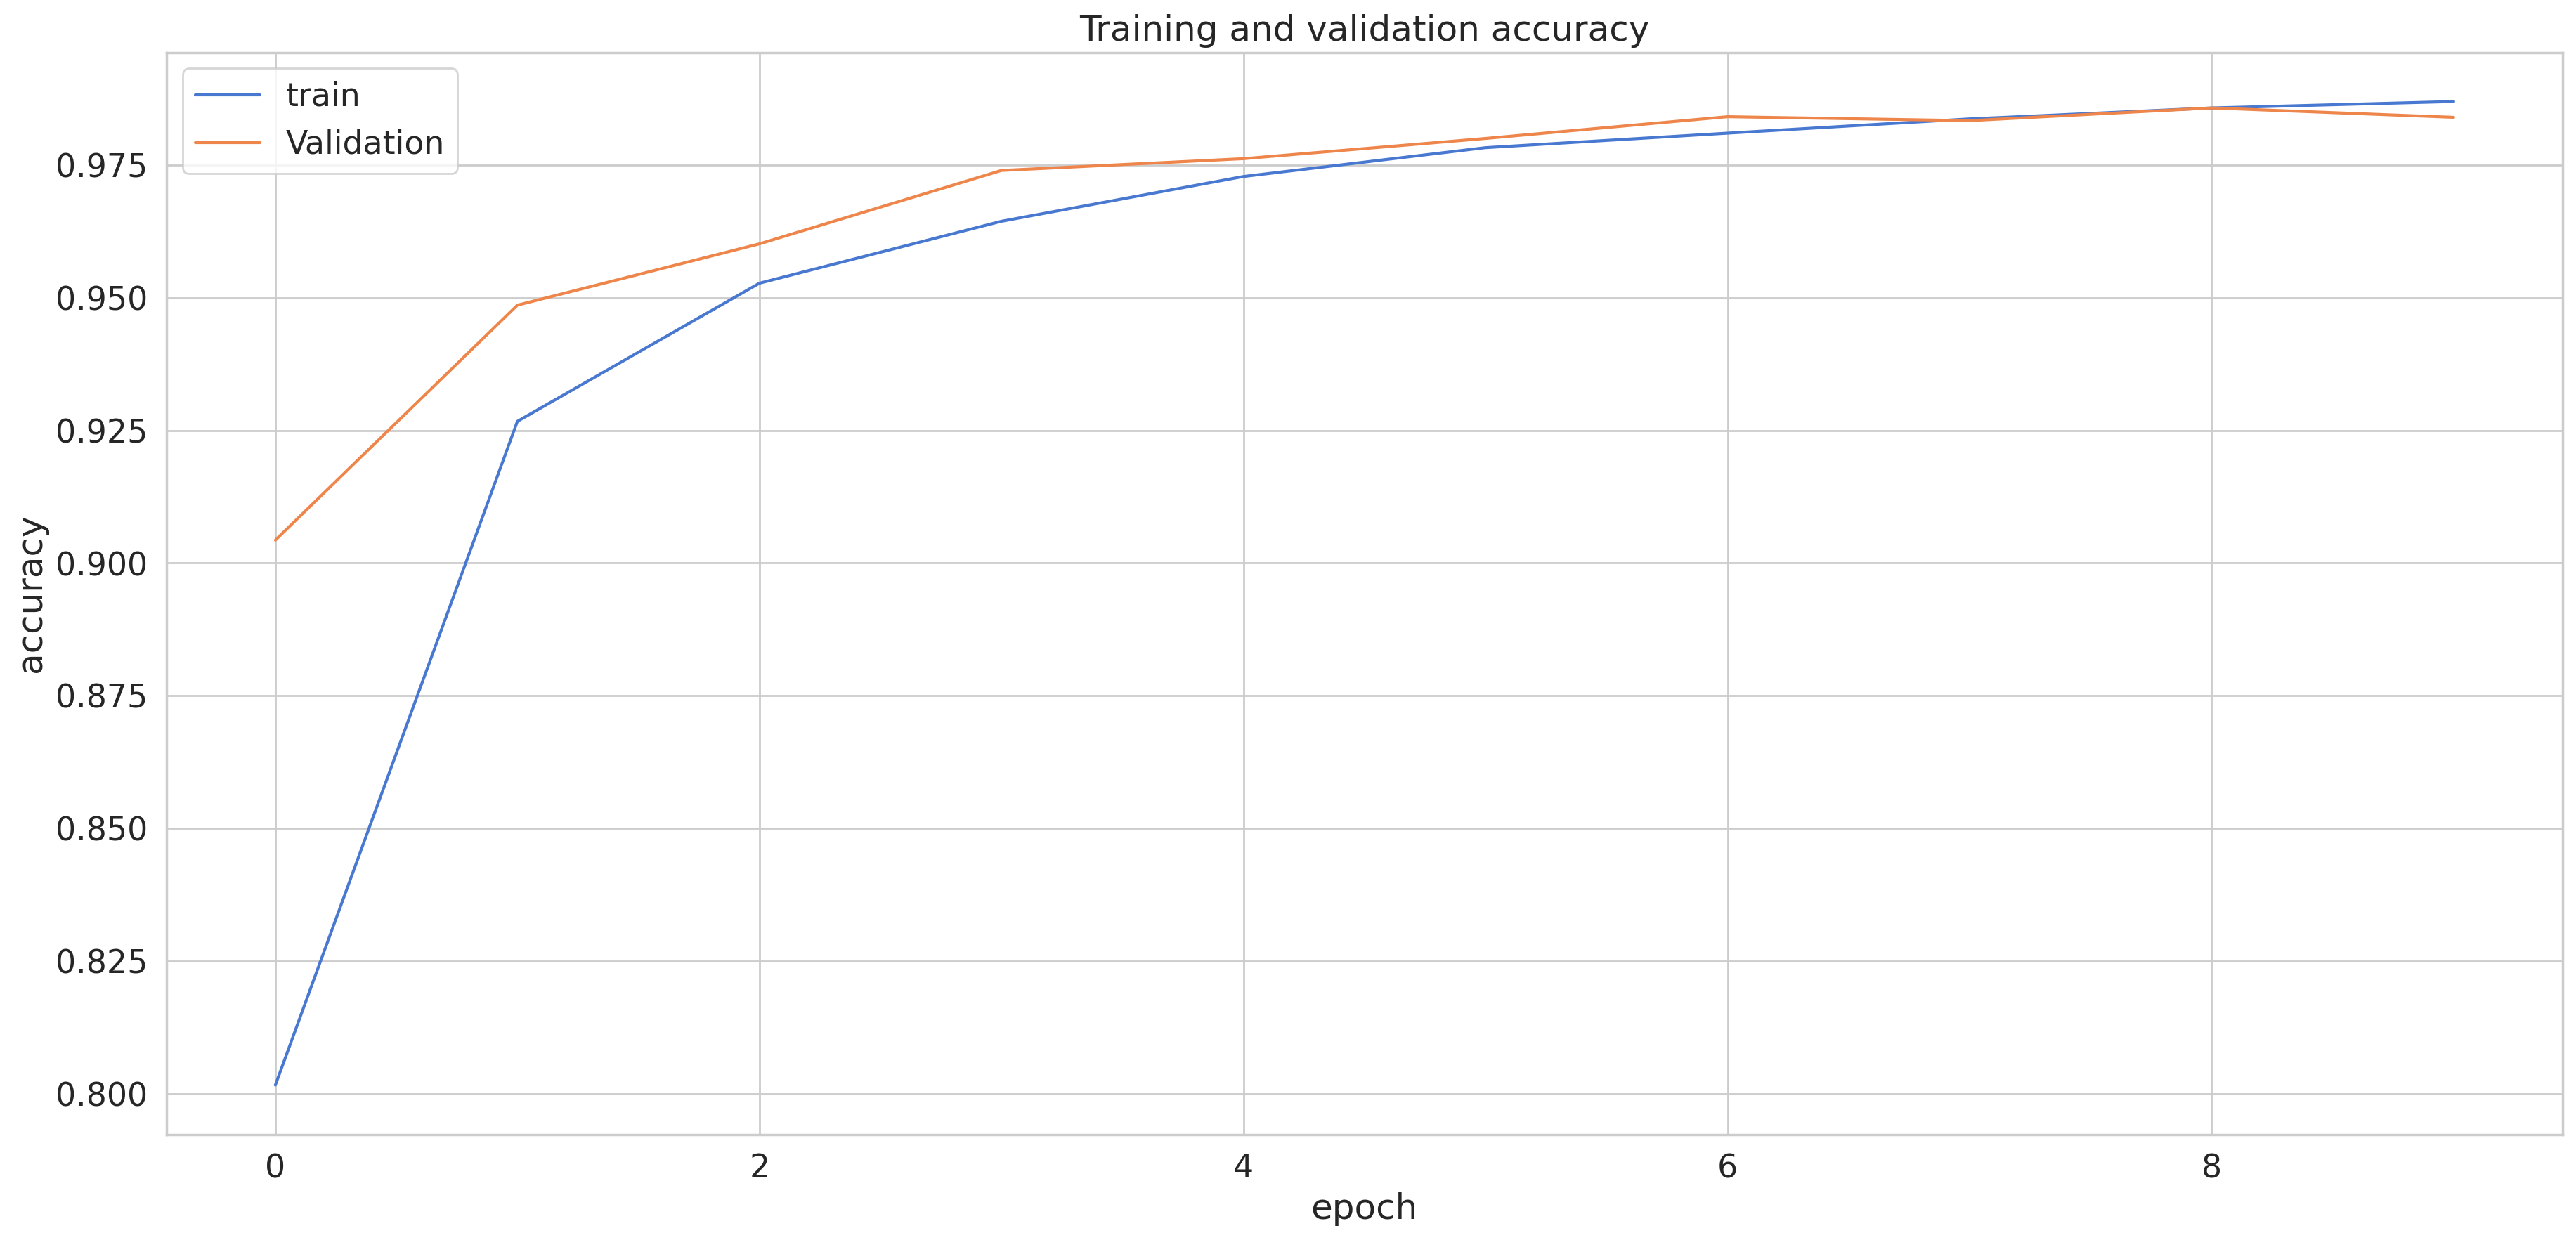

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 6s 6ms/step
f1_score =  0.9847873334657679
0.9847932981242032
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.96      0.95      0.96      2458
           3       0.95      0.96      0.95      2007
           4       0.99      0.99      0.99      1198
           5       0.98      0.99      0.99       968

    accuracy                           0.98     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

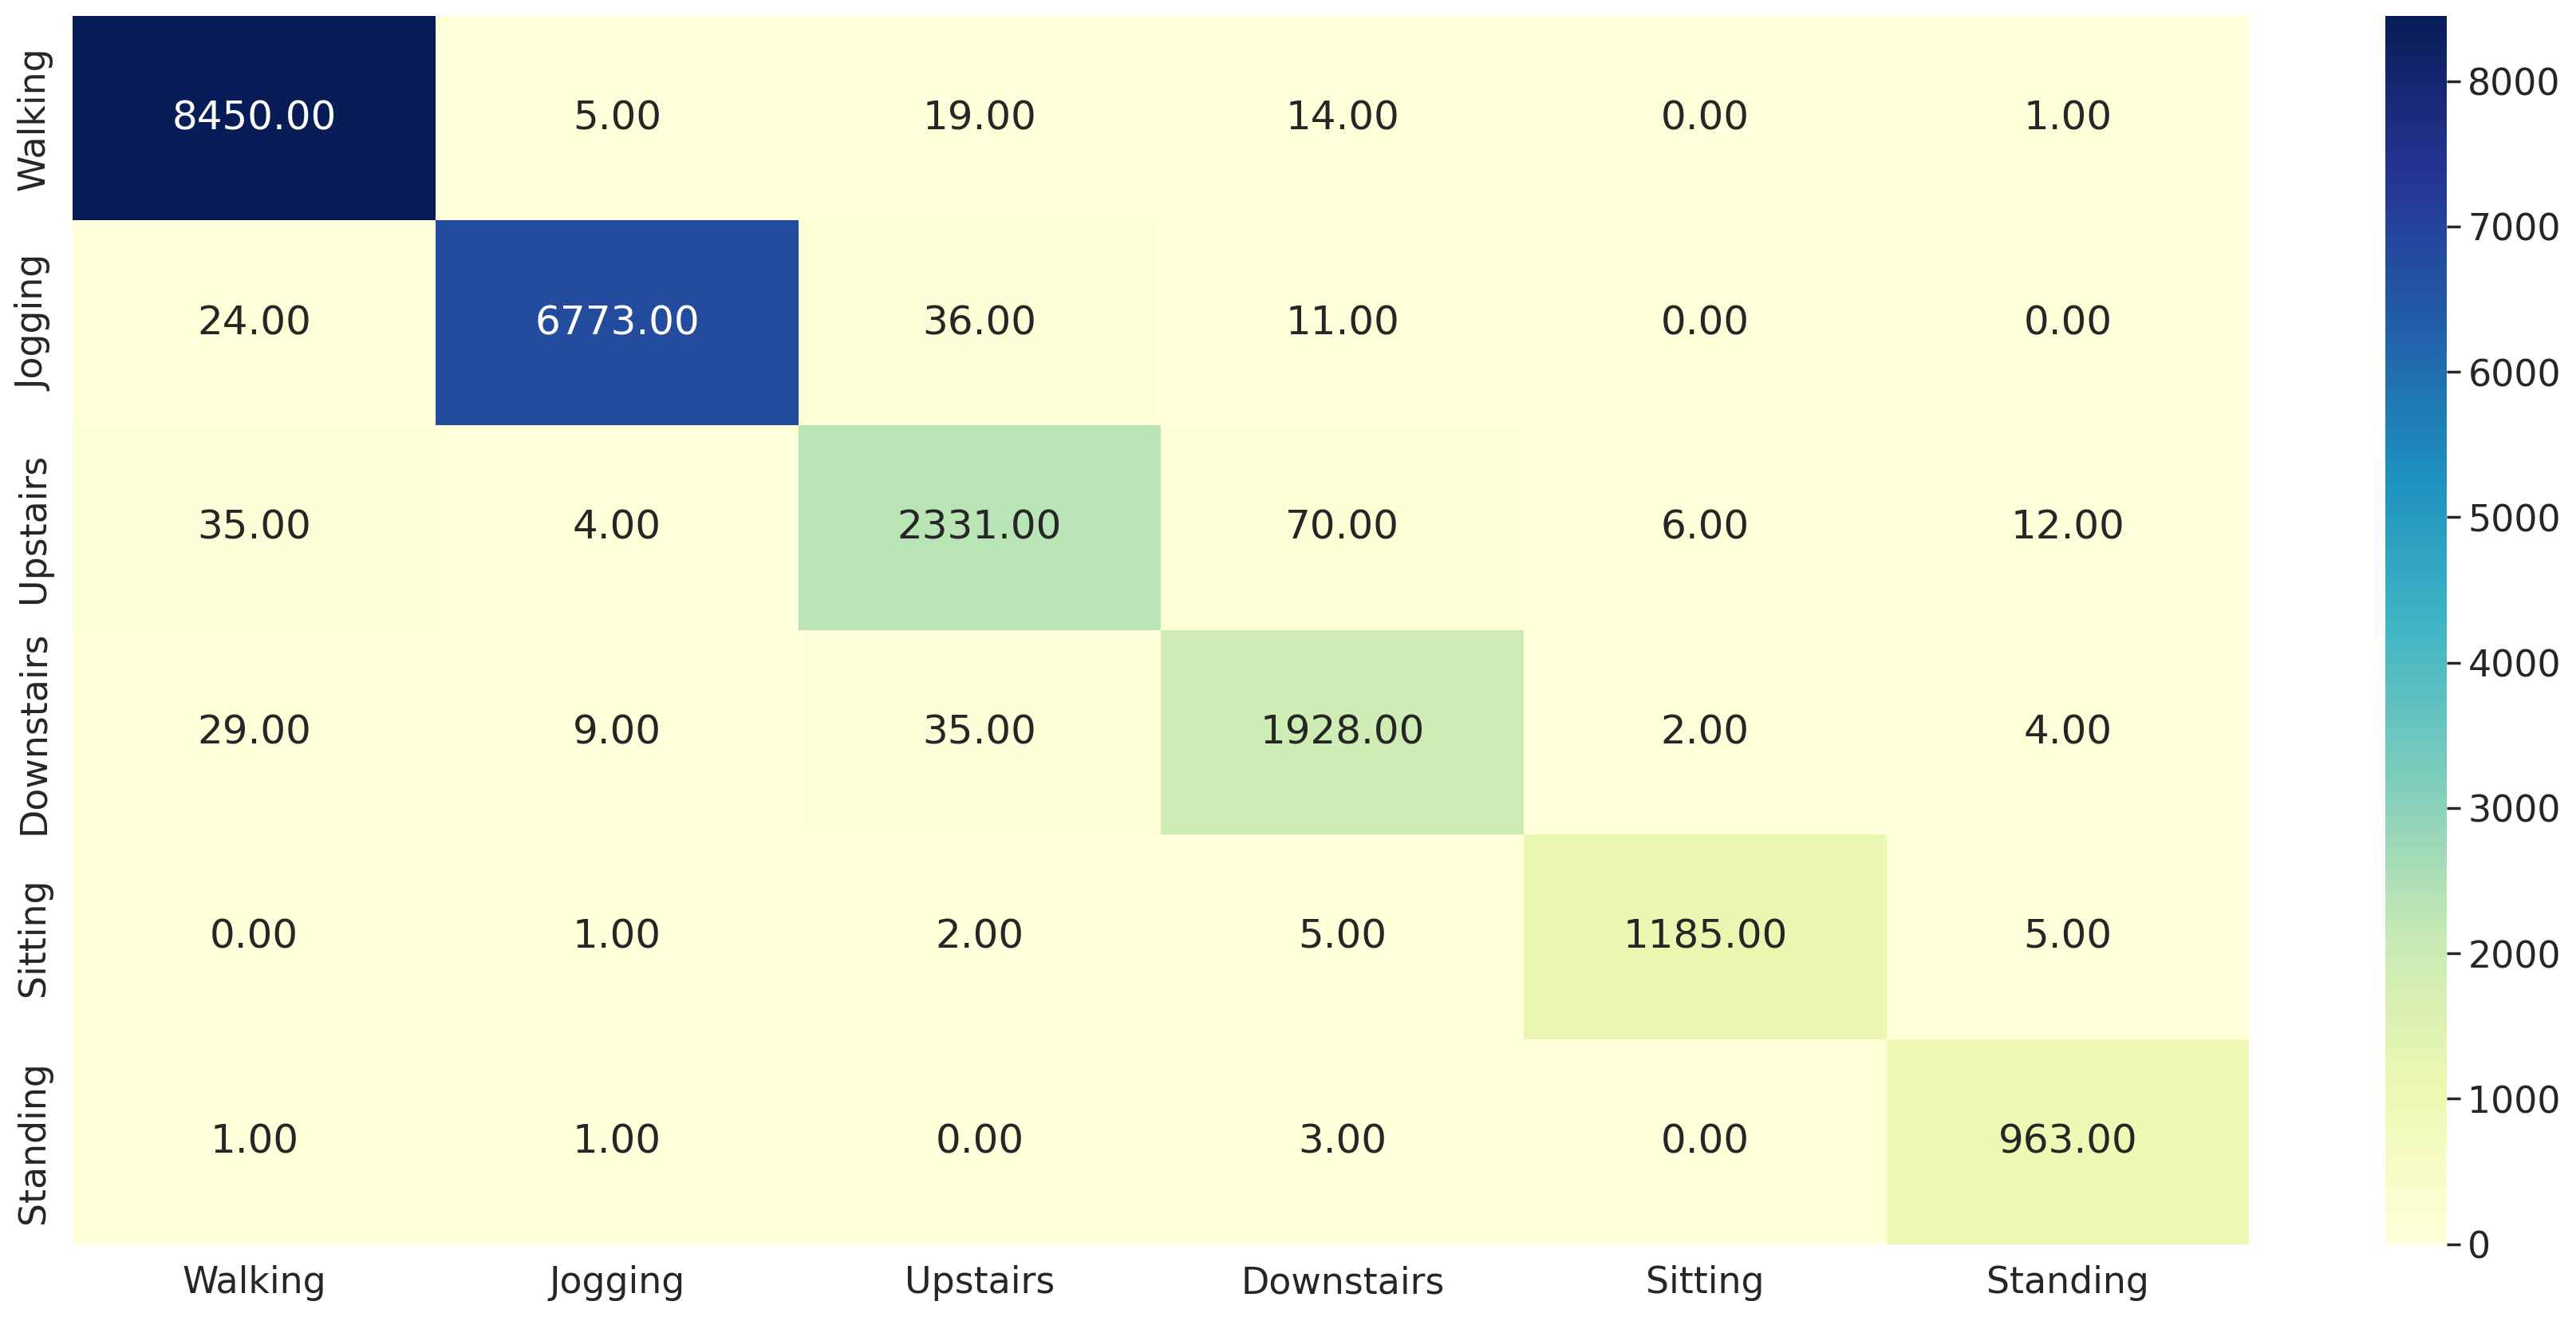

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [31]:
model = Sequential()
# RNN layer
model.add(GRU(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))


model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           51072     
                                                                 
 dropout_11 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_13 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_13 (GRU)                (None, 50, 128)          

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 23s 24ms/step - loss: 0.5973 - accuracy: 0.7946 - val_loss: 0.3621 - val_accuracy: 0.8763
Epoch 2/10
550/550 [==============================] - 12s 22ms/step - loss: 0.2495 - accuracy: 0.9169 - val_loss: 0.1663 - val_accuracy: 0.9464
Epoch 3/10
550/550 [==============================] - 12s 22ms/step - loss: 0.1530 - accuracy: 0.9507 - val_loss: 0.1100 - val_accuracy: 0.9651
Epoch 4/10
550/550 [==============================] - 12s 22ms/step - loss: 0.1147 - accuracy: 0.9629 - val_loss: 0.0894 - val_accuracy: 0.9734
Epoch 5/10
550/550 [==============================] - 12s 22ms/step - loss: 0.0915 - accuracy: 0.9713 - val_loss: 0.0984 - val_accuracy: 0.9675
Epoch 6/10
550/550 [==============================] - 12s 21ms/step - loss: 0.0758 - accuracy: 0.9763 - val_loss: 0.0681 - val_accuracy: 0.9791
Epoch 7/10
550/550 [==============================] - 12s 21ms/step - loss: 0.0656 - accuracy: 0.9806 - val_loss: 0.0565 - val_accuracy:

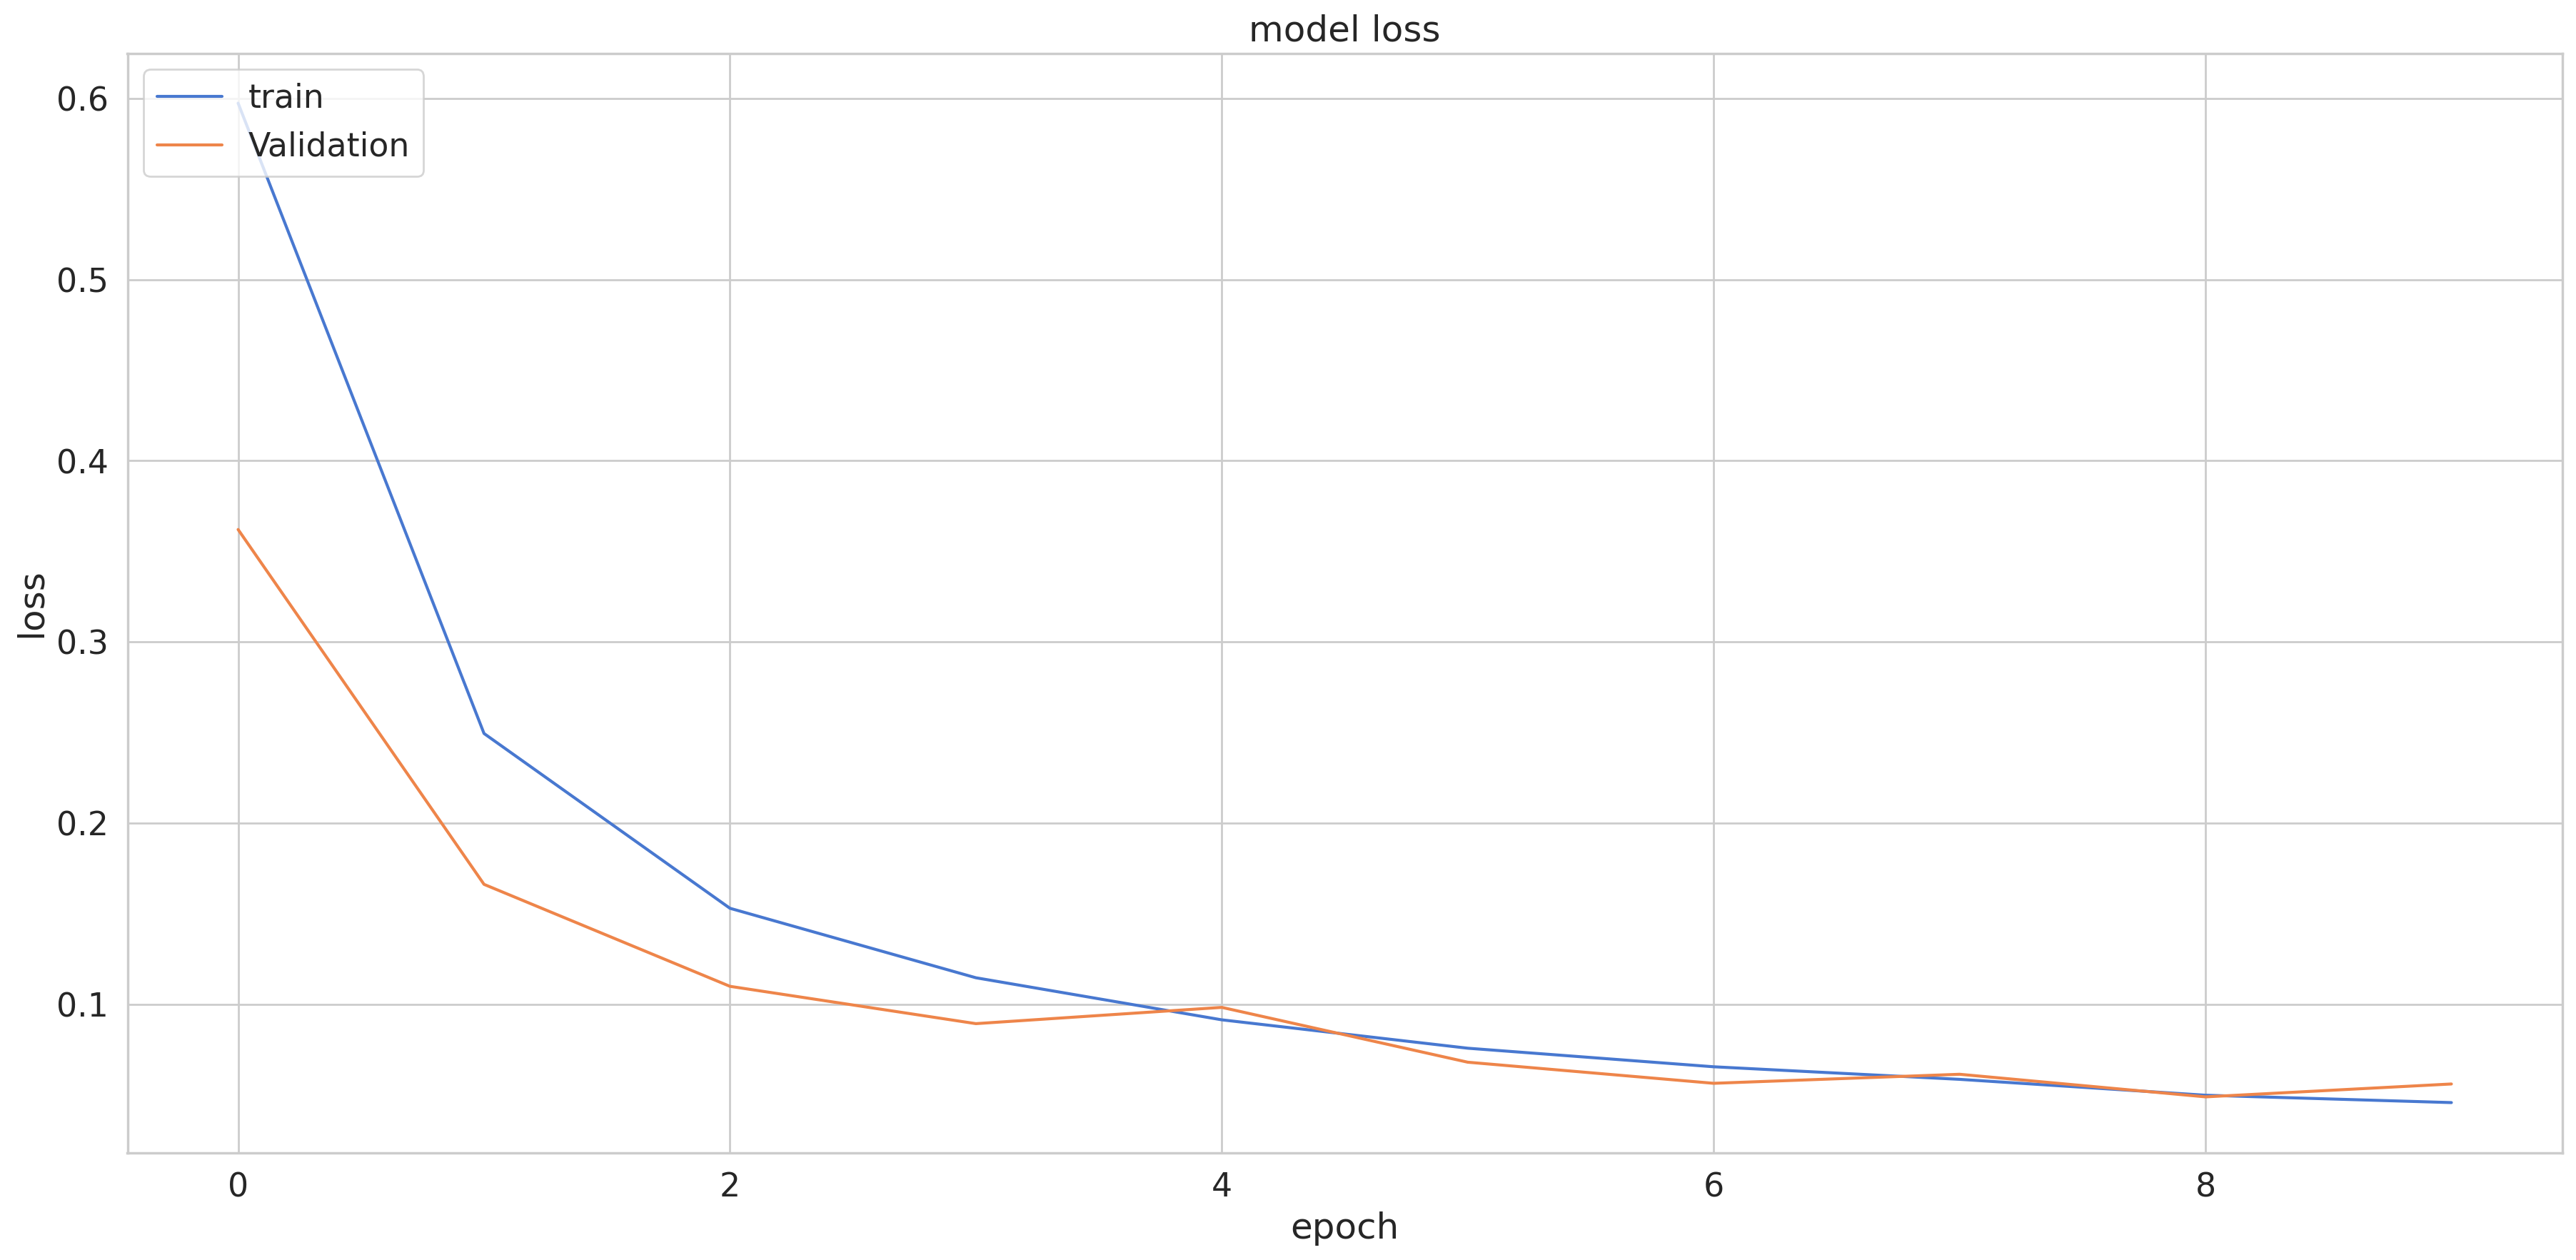

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

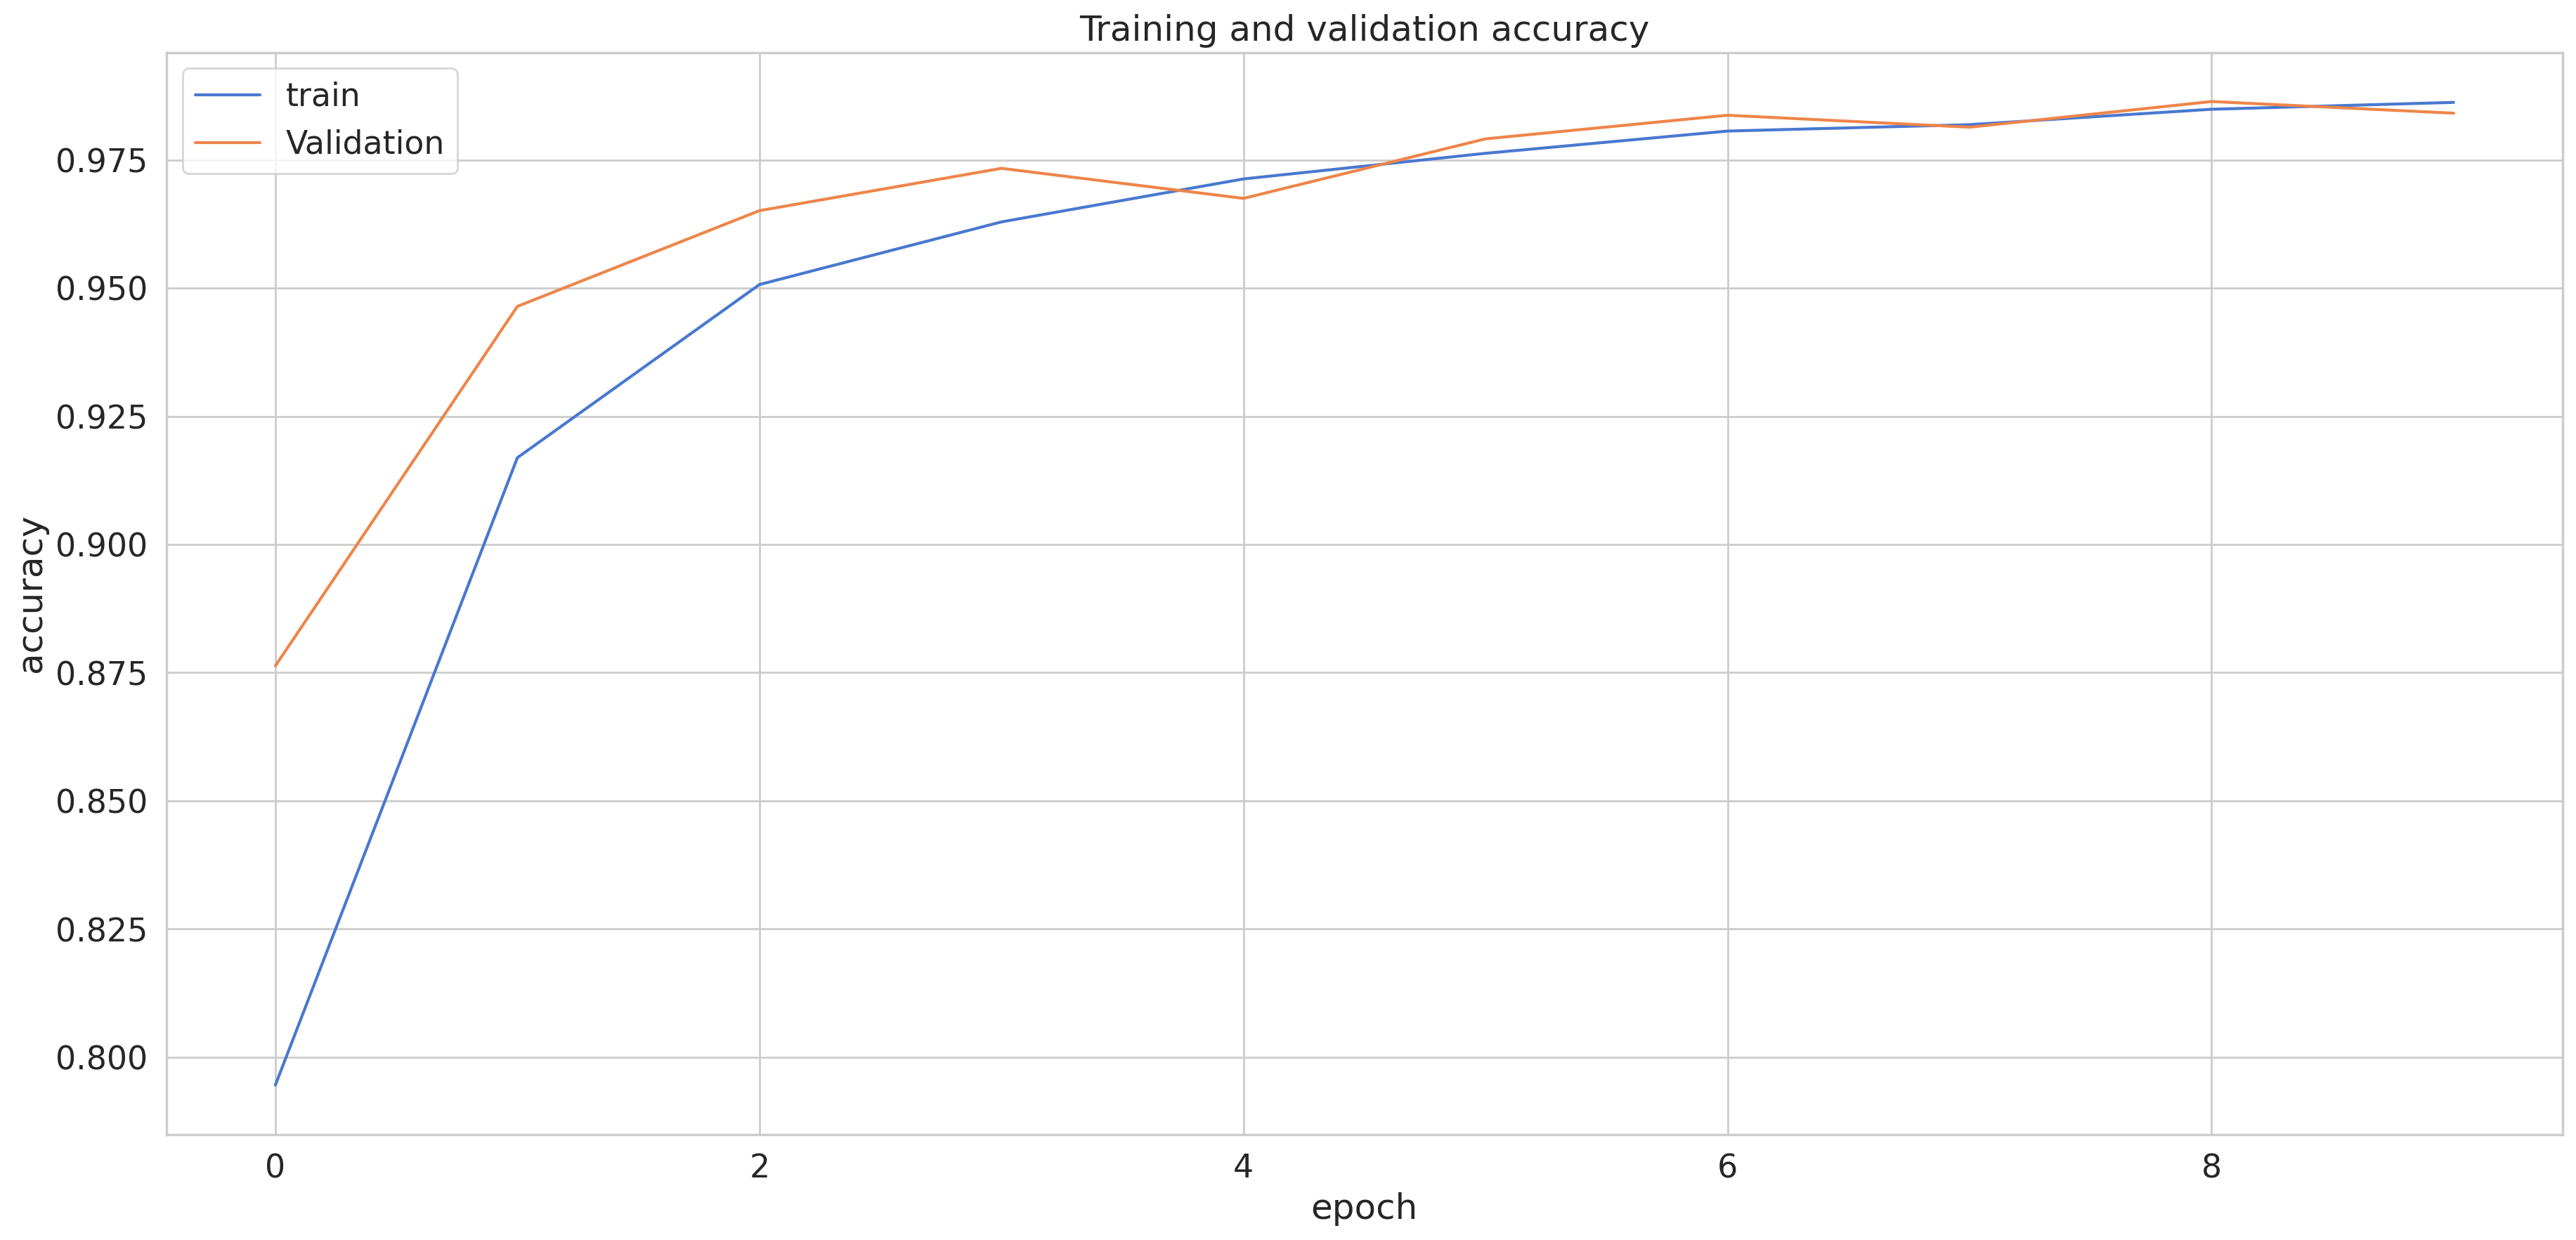

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 7s 8ms/step
f1_score =  0.9844189347013963
0.9843835366964123
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.94      0.97      0.95      2458
           3       0.97      0.94      0.96      2007
           4       1.00      0.99      0.99      1198
           5       0.97      1.00      0.98       968

    accuracy                           0.98     21964
   macro avg       0.98      0.98      0.98     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

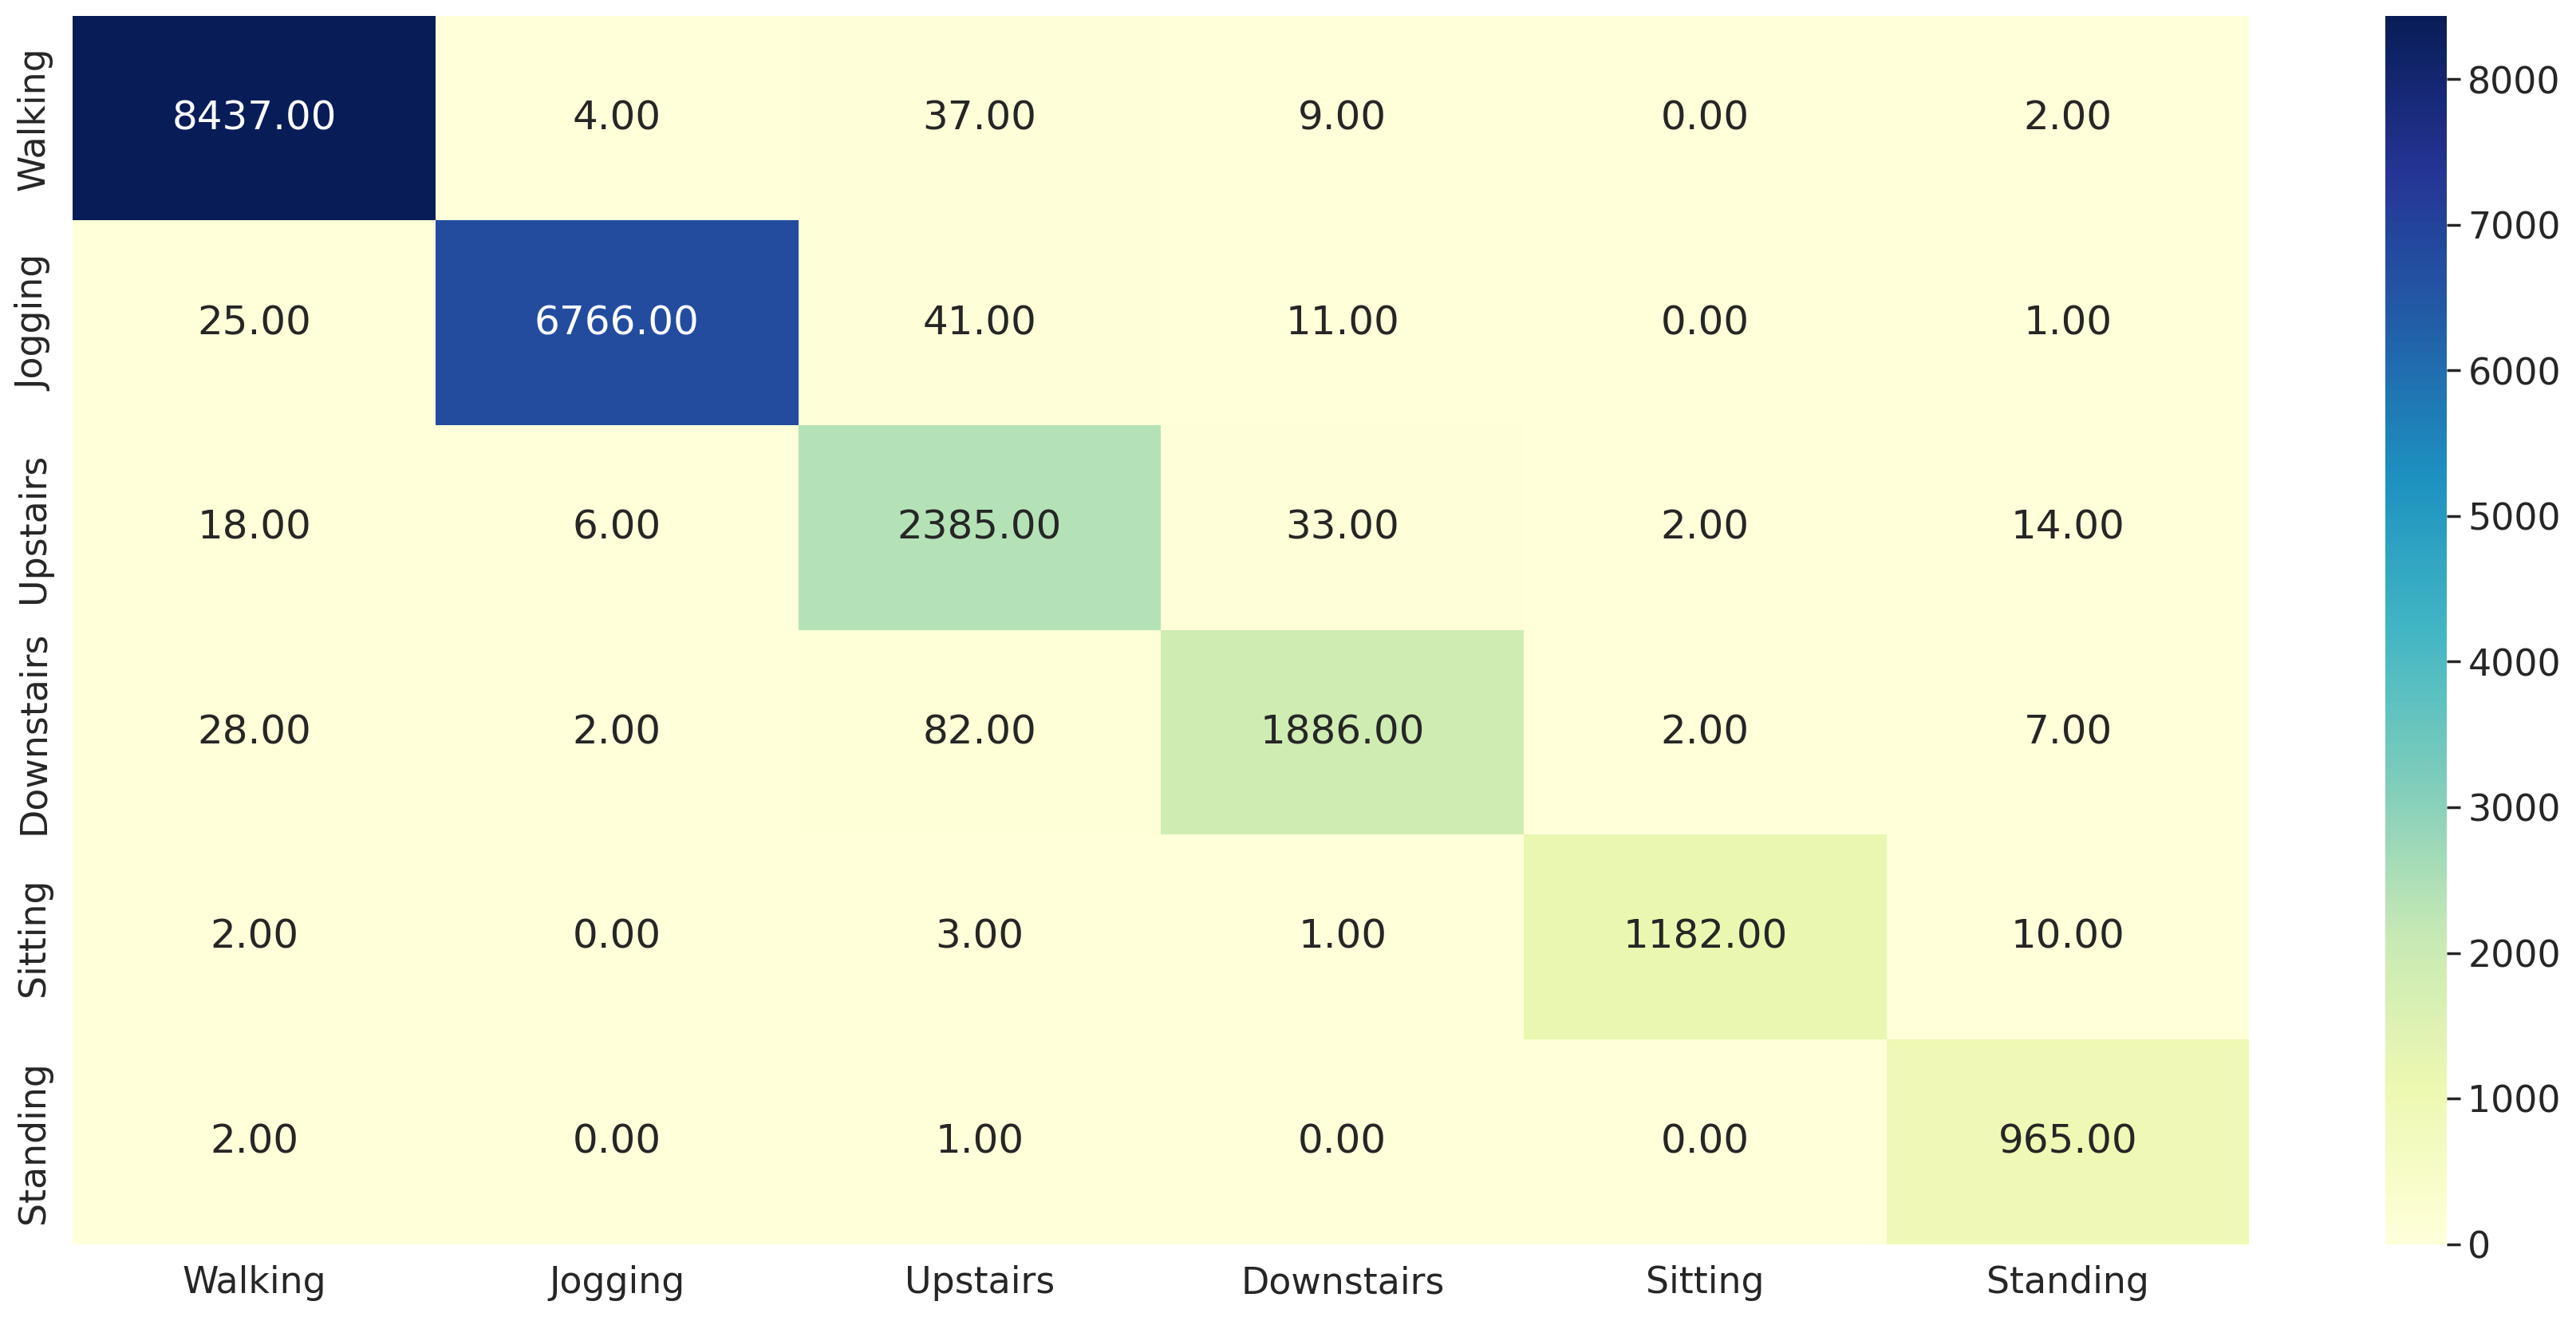

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')